# SPDR Sector ETF Analysis

This notebook will essentially be a continuation of the previous notebook that tracked the performance of market indexes qualitatively over different time horizons. This notebook will still address the same time horizons, however because these ETFs represent more specific sectors of the stock market, their performances may diverge from the behavior observed and modeled in the previous notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE

import datetime as dt

# New import of my custom class
from classification_classes import Model
from spider_classes import Materials, Energy, Financials, Industrials, Technology, Staples, Utilities, Health, \
Consumer, Real_Estate, Communication_Services

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 35)
sns.set_style("dark")

In [2]:
import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

### New container for feature importances

In [3]:
# Class for collecting coefficients of models based on economic features

class Importance():
    df = pd.DataFrame(columns=['Interest Rates', 'GDP', 'ATR', 'lowest_bollinger_band', 'MACD', \
                                    'lower_bollinger_band', 'upper_bollinger_band', '20_day_SMA', \
                                    'one_up_bollinger_band', 'Close', 'High', 'Adj Close', 'Low', 'RSI', \
                                    'Open', 'dollar_volume(M)', 'Volume', 'garman_klass_vol', 'SMB', 'CMA', 'HML',\
                                    'RMW', 'Mkt-RF', 'Quarter_1', 'Quarter_2', 'Quarter_3', 'Quarter_4', \
                              'cycle_year_1', 'cycle_year_2', 'cycle_year_3', 'cycle_year_4'])
    
    # Init method
    def __init__(self, coefs):
        self.dict = coefs
    
        # Add the metrics to the class dataframe
        idx = len(Importance.df)
        Importance.df.loc[idx] = self.dict
    
    
    def add_coefs(self, coefs):
        idx = len(Importance.df)
        Importance.df.loc[idx] = coefs
        
    
    def __str__(self):
      return "Feature Importance/Coefficient DataFrame"
        

In [709]:
# These functions add changes in percentage at the target dates

def one_month_price_change(df, num="One"):
    for ticker in list(df["Ticker"].unique()):
        ticker_df = df[df["Ticker"] == ticker]

        for index, row in ticker_df.iterrows():
            try:
                one_month_later_value = row[f"{num.lower()}_months_later"]
                if not pd.isna(one_month_later_value):
                    ticker_df.at[index, f"{num}_Month_Change"] = (ticker_df.loc[one_month_later_value, "Adj Close"] - row["Adj Close"]) / row["Adj Close"]
                else:
                    # Handle the case where one_month_later is NaN (NaT)
                    ticker_df.at[index, f"{num}_Month_Change"] = np.nan
            except KeyError:
                # Handle the KeyError exception here if necessary
                ticker_df.at[index, f"{num}_Month_Change"] = np.nan
           
        df.loc[df["Ticker"] == ticker, f"{num}_Month_Change"] = ticker_df[f"{num}_Month_Change"]
    
    return df



def three_month_price_change(df, num="Three"):
    return one_month_price_change(df, num)
    
    
def six_month_price_change(df, num="Six"):
    return one_month_price_change(df, num)


def twelve_month_price_change(df, num="Twelve"):
    return one_month_price_change(df, num)

<hr style="border: 3px solid black">

# SPDR Data

The term "SPDR" stands for "Standard & Poor's Depositary Receipts." These ETFs were literally the first Exchange Traded Funds offered to the public markets that allowed investors to gain access to large sectors of the market or entire indices depending on your preference. As the previous notebook analyzed the major market indices, this notebook will focus on the sector indices to provide a different perspective. The process for modeling will be largely the same. Because so many of the models from the previous notebook performed so well without overfitting, I did not tune them using GridsearchCV. Depending on performances in this notebook, there may be more tuning.

In [710]:
# Loading the data

df = pd.read_csv("./Files/Spiders_Final.csv")
print(df.shape)
df.head()

(59633, 33)


,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),GDP,Interest Rates,Mkt-RF,SMB,HML,RMW,CMA,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive
0,1998-12-22,XLB,12.011767,20.828125,20.828125,20.750000,20.781250,1900.0,-0.116068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0228,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,1.0,1.0,1.0,1.0
1,1998-12-22,XLE,12.448157,23.265625,23.390625,23.187500,23.312500,15200.0,-0.152028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1892,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,0.0,1.0,1.0,1.0
2,1998-12-22,XLF,11.612926,18.937855,19.052092,18.849005,19.052092,55887.0,-0.094617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6490,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,0.0,1.0,1.0,1.0
3,1998-12-22,XLI,14.971390,23.281250,23.281250,23.203125,23.203125,600.0,-0.074152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0090,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,1.0,1.0,1.0,1.0
4,1998-12-22,XLK,24.243126,32.046875,32.500000,31.781250,32.406250,300500.0,-0.032286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2851,9293.991,0.0439,0.0,-0.0029,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,1.0,1.0,1.0,1.0


In [711]:
# Feature Transformations and additions

df["Date"] = pd.to_datetime(df["Date"])
df["Quarter"] = df["Date"].dt.quarter.astype(str)
df["cycle_year"] = (df["Date"].dt.year % 4)
df['cycle_year'] = df['cycle_year'].apply(lambda x: 4 if x == 0 else x).astype(str)
df.set_index("Date", inplace=True)

In [712]:
# Adding the change in price for the entire dataframe - takes several minutes to run

one_month_price_change(df)
three_month_price_change(df)
six_month_price_change(df)
twelve_month_price_change(df)

,Ticker,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),...,HML,RMW,CMA,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive,Quarter,cycle_year,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-12-22,XLB,12.011767,20.828125,20.828125,20.750000,20.781250,1900.0,-0.116068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0228,...,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,1.0,1.0,1.0,1.0,4,2,0.012003,0.078634,0.256418,0.218478
1998-12-22,XLE,12.448157,23.265625,23.390625,23.187500,23.312500,15200.0,-0.152028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1892,...,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,0.0,1.0,1.0,1.0,4,2,-0.028878,0.075714,0.209873,0.150695
1998-12-22,XLF,11.612926,18.937855,19.052092,18.849005,19.052092,55887.0,-0.094617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6490,...,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,0.0,1.0,1.0,1.0,4,2,-0.009383,0.099426,0.099781,0.012503
1998-12-22,XLI,14.971390,23.281250,23.281250,23.203125,23.203125,600.0,-0.074152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0090,...,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,1.0,1.0,1.0,1.0,4,2,0.010738,0.084570,0.272791,0.213059
1998-12-22,XLK,24.243126,32.046875,32.500000,31.781250,32.406250,300500.0,-0.032286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2851,...,-0.0043,-0.0009,0.0078,1999-01-22,1999-03-22,1999-06-22,1999-12-22,1.0,1.0,1.0,1.0,4,2,0.084349,0.107753,0.223306,0.655810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-25,XLP,67.940002,67.940002,68.239998,67.419998,67.599998,11351100.0,0.000063,43.174669,66.122483,66.838991,67.555500,68.272008,68.988516,0.820658,-0.697945,771.1938,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,NaN,NaN,NaN
2023-10-25,XLRE,32.189999,32.189999,32.650002,32.099998,32.540001,8454400.0,0.000099,33.847969,32.120178,32.866839,33.613500,34.360161,35.106822,0.626503,-0.653811,272.1471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,NaN,NaN,NaN
2023-10-25,XLU,59.349998,59.349998,59.470001,58.680000,58.919998,20654700.0,0.000069,46.305928,56.095167,57.214334,58.333500,59.452666,60.571832,1.211284,-0.672943,1225.8564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,NaN,NaN,NaN


In [714]:
df.shape

(59633, 38)

In [715]:
df.dropna(inplace=True)
df.shape

(56597, 38)

In [716]:
# Cell creates a dataframe of the NORMALIZED value counts for each ETF and each time target

tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY',
       'XLRE', 'XLC']

# Value Counts for Targets of Each SPDR

values = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values.loc[num] = (df[df["Ticker"]==i]['One_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 3 Month Target

values3 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values3.loc[num] = (df[df["Ticker"]==i]['Three_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 6 Month Target

values6 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values6.loc[num] = (df[df["Ticker"]==i]['Six_Month_Positive'].value_counts(normalize=True)*100).round(2)

# 12 Month Target

values12 = pd.DataFrame(columns=[0, 1])

for num, i in enumerate(tickers):
    values12.loc[num] = (df[df["Ticker"]==i]['Twelve_Month_Positive'].value_counts(normalize=True)*100).round(2)

# Concat all DFs
    
value_cnts = pd.concat([values, values3, values6, values12], axis=1)

super_column_titles = ['One', 'Month', 'Three', 'Month', 'Six', 'Month', 'Twelve', 'Month']

multi_index = pd.MultiIndex.from_tuples(list(zip(super_column_titles, value_cnts.columns)))

value_cnts.columns = multi_index

value_cnts.rename(index={0:'XLB', 1:'XLE', 2:'XLF', 3:'XLI', 4:'XLK', 5:'XLP', 6:'XLU', 7:'XLV', 8:'XLY',
       9:'XLRE', 10:'XLC'}, inplace=True)

# Value Counts of ETFs for each time horizon

value_cnts

,One,Month,Three,Month,Six,Month,Twelve,Month
,0,1,0,1,0,1,0,1
XLB,39.75,60.25,35.78,64.22,32.02,67.98,29.51,70.49
XLE,42.81,57.19,37.71,62.29,35.28,64.72,33.66,66.34
XLF,41.54,58.46,35.90,64.10,35.90,64.10,36.33,63.67
XLI,39.92,60.08,34.26,65.74,32.33,67.67,25.34,74.66
XLK,39.06,60.94,33.31,66.69,30.38,69.62,24.89,75.11
XLP,37.32,62.68,32.07,67.93,26.24,73.76,18.18,81.82
XLU,38.08,61.92,33.54,66.46,29.05,70.95,22.51,77.49
XLV,38.38,61.62,32.44,67.56,31.23,68.77,23.08,76.92
XLY,37.66,62.34,34.53,65.47,30.81,69.19,25.15,74.85


### Interpretation of the above table:

As you can see, the longer the time horizon, the more likely that any ETF will have increased in value. XLRE and XLF, real estate and financials respectively, each failed to perform better over 6 months compared to 3 months, but those are literally the only exceptions. XLRE and XLC also have not existed for as long as these other SPDR funds, and therefore there is a bit less data for those two ETFs.

# Visual Inspection

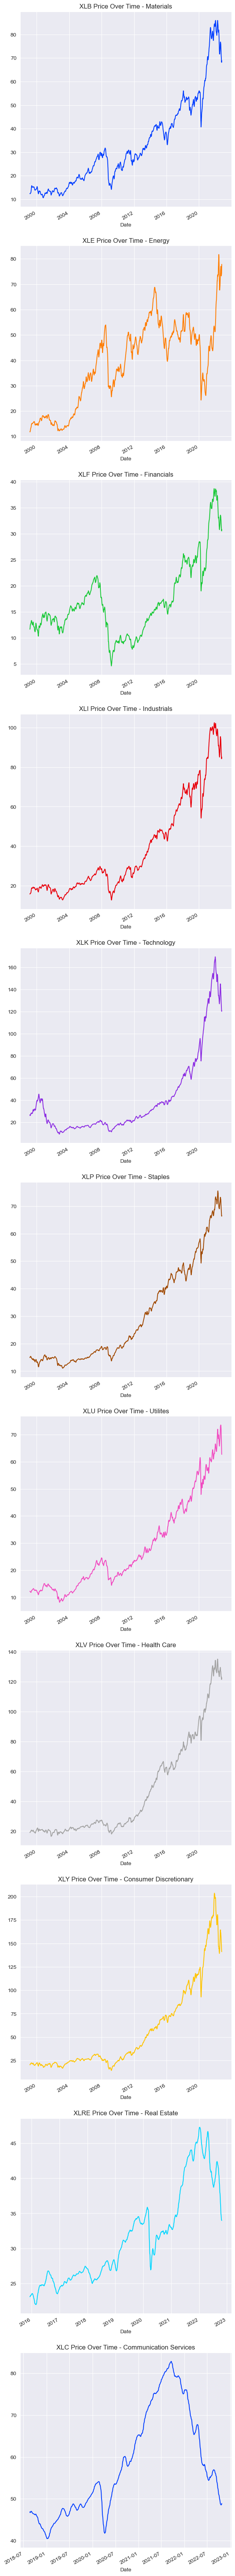

In [717]:
# Plotting price over time
sns.set_style("darkgrid")
sectors = ["Materials", "Energy", "Financials", "Industrials", "Technology", "Staples", "Utilites", "Health Care",\
          "Consumer Discretionary", "Real Estate", "Communication Services"]

palette = sns.color_palette("bright", n_colors=11)
fig, ax = plt.subplots(nrows=11, figsize=(7,96))

for num, i in enumerate(tickers):
    df[df["Ticker"]==i]["Adj Close"].rolling(window=20).mean().\
    plot(kind="line", color=palette[num], title=f"{i} Price Over Time - {sectors[num]}", ax=ax[num])

### Monthly Statistics

In [718]:
df.reset_index(inplace=True)
df.set_index(["Date", "Ticker"], inplace=True)

##### Keep in mind that XLC and XLRE do not have as much data, and so their performance might be noisy

In [719]:
# XLE has highest average monthly stock gain not accounting for dividends/expenses

# Creates multi-index columns, then re-structures the df by Monthly groups
monthly_data = df.unstack("Ticker").resample('M')

# Subtract the price at month's end from the price and month's start divided by price at month's start * 100 for %
monthly_percentage_change = monthly_data['Adj Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)

# Sort the last of mean percentage monthly gains
monthly_percentage_change.mean().sort_values(ascending=False)

Ticker
XLE     0.719806
XLI     0.715088
XLRE    0.683641
XLY     0.674212
XLV     0.659087
XLB     0.628262
XLU     0.587437
XLK     0.547366
XLF     0.471629
XLP     0.452161
XLC     0.094741
dtype: float64

In [720]:
# Fuller Picture of monthly returns

monthly_percentage_change.describe()

Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
count,5975.000000,1067.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,1738.000000,5975.000000,5975.000000,5975.000000
mean,0.628262,0.094741,0.719806,0.471629,0.715088,0.547366,0.452161,0.683641,0.587437,0.659087,0.674212
std,6.065142,6.467678,7.278915,6.439148,5.422227,6.610238,3.559081,5.220937,4.369821,4.166507,5.682687
min,-21.095915,-15.528095,-36.920879,-27.014192,-21.390413,-24.865885,-13.237411,-19.129234,-14.998888,-14.104289,-17.739845
25%,-2.556944,-5.458970,-2.830217,-2.496501,-2.193276,-2.972382,-1.581248,-1.478468,-1.758879,-1.582004,-2.307308
50%,0.636818,1.158390,0.392216,0.657136,0.853207,1.068237,0.862412,0.846156,1.023536,0.643068,0.884793
75%,3.849910,3.705945,4.894552,3.906772,3.778352,4.274348,2.709542,3.900496,3.271118,2.853546,3.774150
max,23.590361,18.361571,37.581468,24.977050,17.676029,26.440601,10.991583,16.483496,11.876575,17.040225,24.439696


### Yearly statistics - taken from year start - year end, averages of each, so can be misleading

In [721]:
# XLC has highest average yearly stock gain not accounting for dividends/expenses

yearly_data = df.unstack("Ticker").resample('Y')
yearly_percentage_change = yearly_data['Adj Close'].transform(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0] * 100)
yearly_percentage_change.mean().sort_values(ascending=False)

Ticker
XLC     11.921543
XLE     10.651872
XLRE    10.627250
XLY     10.190422
XLK      9.713185
XLB      9.539807
XLI      9.243045
XLV      9.016944
XLU      8.744014
XLP      7.635755
XLF      6.713711
dtype: float64

In [722]:
# Fuller picture of stock appreciation over 1 year beginning and ending periods

yearly_percentage_change.describe()

Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
count,5975.000000,962.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,1716.000000,5975.000000,5975.000000,5975.000000
mean,9.539807,11.921543,10.651872,6.713711,9.243045,9.713185,7.635755,10.627250,8.744014,9.016944,10.190422
std,19.633891,23.908520,25.961128,21.406949,17.849276,26.748360,12.547828,23.061193,15.996774,12.786017,19.542435
min,-43.506963,-33.255291,-39.070507,-53.995783,-37.693424,-43.517478,-19.809941,-28.209040,-29.777610,-22.497939,-31.930355
25%,-6.030355,17.706276,-14.037703,-6.814668,-1.803619,0.540779,2.841797,-1.821364,1.786397,1.534570,0.061182
50%,15.914757,25.430945,12.714313,11.017481,12.762142,13.688117,10.991900,5.197603,12.325627,7.664282,13.662277
75%,22.910308,29.324796,26.888772,25.142452,23.246328,32.318574,13.931282,31.700130,20.746765,17.136342,27.424322
max,42.940711,29.324796,57.688412,36.652029,37.253084,49.759204,28.191247,50.973780,30.744411,38.662447,39.814892


### Notes
While some of these sector ETFs move in concert, there is clearly observable performance dislocation between other ETFs. Also, certain sectors spiders pay dividends. A dividend is a payout of a company's earnings given directly to its shareholders, and dividends are generally described as the percentage of the current asset price to be paid out annually. For individual assets dividend rates and schedules can change depending on performance, however when dealing with a basket of stocks, like those within an ETF, dividends and their structures are usually more reliably consistent. Each of these ETFs also has an associated expense ratio, or amount taken out of your investment to fund the operations of the ETF.
### Dividends of ETFs
- XLB 2.11%
- XLE 3.50%
- XLF 2.00%
- XLI 1.83%
- XLK 0.97%
- XLP 2.81%
- XLU 3.71%
- XLV 1.77%
- XLY 0.87%
- XLRE 3.99%
- XLC 1.06%

### Expense Ratios
Each of the sector spiders has a 0.1% expense ratio. That means that if your investment in a given spider was $1,000 at the start of the year, you would expect to pay an expense of 0.1% on that amount, or 1 dollar. 

### Adjusted Close
As you look at several of the above tables, you may wonder why we use "Adj Close" instead of "Close" for calculating a daily price. Adjusted close takes into account both dividends and future stock splits. Stock splits occur when a company chooses to artificially increase the amount of stocks that are trading by taking the current volume of stock and "splitting" it into x-number of pieces. A 10-to-1 split would mean that if you owned one share of a company or one share of an ETF before the split, afterwards you would own 10 shares, and each would be worth one tenth of the price of your original holding, so your investment is still the same size, but it is spread over more individual shares. 

<hr style="border: 2px solid green">

# Model Prep
Now that we have performed some superficial inspection of these ETFs, we can begin model iterations. 

### Splitting Data in Prep for Models

In [724]:
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)

In [725]:
# DFs for each index

# Materials
materials_df = df[df["Ticker"]== "XLB"]

# Energy
energy_df = df[df["Ticker"]== "XLE"]

# Financials
financial_df = df[df["Ticker"]== "XLF"]

# Industrials
industrial_df = df[df["Ticker"]== "XLI"]

# Technology
tech_df = df[df["Ticker"]== "XLK"]

# Staples
staples_df = df[df["Ticker"]== "XLP"]

# Utilities
utilities_df = df[df["Ticker"]== "XLU"]

# Health Care
health_df = df[df["Ticker"]== "XLV"]

# Consumer Discretionary
consumer_df = df[df["Ticker"]== "XLY"]

# Real Estate
real_df = df[df["Ticker"]== "XLRE"]

# Tele-com / communication services
communication_df = df[df["Ticker"]== "XLC"]

In [731]:
# df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/FULL_DATA_W_PERC_CHANGES.csv')

In [727]:
# Definition to handle splits using df, and string for time horizon

def select_data(df, time_horizon:str):
    
    X = df.drop(columns=["Ticker", 'one_months_later', 'three_months_later', 'six_months_later', \
                         'twelve_months_later', 'One_Month_Positive', 'Three_Month_Positive', 'Six_Month_Positive',\
                         'Twelve_Month_Positive', 'One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                         'Twelve_Month_Change'])
    y = df[f'{time_horizon.title()}_Month_Positive']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=131)
    return X_train, X_test, y_train, y_test

In [657]:
%%writefile other_functions.py
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


def compare_curves(list_of_models):
    sns.set_style("dark")
    # Color Palette
    colors = sns.color_palette("Paired", n_colors=8)
    # Create the plot
    fig, ax = plt.subplots(figsize=(7,7))
    for i in range(len(list_of_models)):
        # get the predict_proba values
        y_hat_hd = list_of_models[i].y_pred_proba[:, 1]

        # Get the FPR and TPR data
        fpr, tpr, thresholds = roc_curve(list_of_models[i].y_test, y_hat_hd)
        # Plot the actual graph
        ax.plot(fpr, tpr, color=colors[i], label=f'{list_of_models[i].name} | AUC: {list_of_models[i].auc:.2f})')

    ax.set_title(f"Comparison of ROC Curves")
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    plt.grid(False);

Overwriting other_functions.py


<hr style="border: 4px solid green">

# Dummy Model

In [18]:
# Preparing for our first batch of models, we will proceed index by index and from time horizons low to high

X_train, X_test, y_train, y_test = select_data(materials_df, "One")

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy1 = Materials("Dummy Model", dummy, X_train, X_test, y_train, y_test)
Materials.model_df

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy Model,0.602544,0.602544,1.0,0.751984,14.325759,0.60241,0.60241,1.0,0.75188,14.330609,0.5


# Pipelines

In [19]:
# Sub-pipe for numeric transformation
num_pipe = Pipeline(steps=[
    ("ss", StandardScaler())
])

# Sub-pipe for categorical transformation
cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column Transformer object to be given to the ultimate pipeline model
ct = ColumnTransformer(transformers=[
    ("num_pipe", num_pipe, selector(dtype_include=np.number)),
    ('cat_pipe', cat_pipe, selector(dtype_include=object))
])

In [47]:
# Pipeline for model fitting and commented out models that will be fit 



                        # Model types/hyperparameters
    
    # LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
    # fit_intercept=True)
    
    
    # KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto', leaf_size=30, p=2, \
#                                 metric='minkowski', metric_params=None, n_jobs=4)
    
#     RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    
#     ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None,)

    # AdaBoostClassifier(estimator=None, n_estimators=50,learning_rate=1.0, algorithm='SAMME.R',\
#                               random_state=13, base_estimator='deprecated')

#     XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)


                                # Normal Protocol

# model_pipe = Pipeline(steps=[
#     ("ct", ct),
#     ("model", XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)  
     
#     )])

# model_pipe.fit(X_train, y_train)

                      
                                # Special protocol for multi ensemble models
        
        
    # VotingClassifier(estimators=[
#         ('et', etc.model),
#         ('rf', rfc.model),
#         ('xg', XGBoost.model)
#     ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)

ct.fit(X_train)
transformed_X_train = pd.DataFrame(ct.transform(X_train), index=X_train.index, columns=ct.get_feature_names_out())
transformed_X_test = pd.DataFrame(ct.transform(X_test), index=X_test.index, columns=ct.get_feature_names_out())

model_pipe = Pipeline(steps=[
    ("model", VotingClassifier(estimators=[
        ('et', etc.model),
        ('rf', rfc.model),
        ('xg', XGBoost.model)
    ], voting='soft', weights=None, n_jobs=4, flatten_transform=True, verbose=False,)
)])
     
model_pipe.fit(transformed_X_train, y_train)

Pipeline(steps=[('model',
                 VotingClassifier(estimators=[('et',
                                               Pipeline(steps=[('ct',
                                                                ColumnTransformer(transformers=[('num_pipe',
                                                                                                 Pipeline(steps=[('ss',
                                                                                                                  StandardScaler())]),
                                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fddad77b460>),
                                                                                                ('cat_pipe',
                                                                                                 Pipeline(steps=[('ohe',
                                                                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                                                                sparse_output=False))]),
                                                                                                 <sk...
                                                                              importance_type=None,
                                                                              interaction_constraints=None,
                                                                              learning_rate=1.0,
                                                                              max_bin=None,
                                                                              max_cat_threshold=None,
                                                                              max_cat_to_onehot=None,
                                                                              max_delta_step=None,
                                                                              max_depth=None,
                                                                              max_leaves=0,
                                                                              min_child_weight=None,
                                                                              missing=nan,
                                                                              monotone_constraints=None,
                                                                              n_estimators=50,
                                                                              n_jobs=4,
                                                                              num_parallel_tree=None,
                                                                              predictor=None,
                                                                              random_state=13, ...))]))],
                                  n_jobs=4, voting='soft'))])

In [49]:
# logreg = Materials("Materials Logistic Regression 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# knn = Materials("Materials KNN 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# rfc = Materials("Materials RFC 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# etc = Materials("Materials ExtraTrees 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# adaboost = Materials("Materials AdaBoost 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# XGBoost = Materials("Materials XGBoost 1-Month", model_pipe, X_train, X_test, y_train, y_test)
# votingC = Materials("Materials Voting Ensemble 1-Month", model_pipe, transformed_X_train, transformed_X_test, y_train, y_test)

Materials.model_df.sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
4,Materials ExtraTrees 1-Month,0.893550,0.904020,0.921111,0.912466,0.280764,0.919009,0.928493,0.937778,0.933112,0.225883,0.975179
3,Materials RFC 1-Month,0.873911,0.877710,0.918889,0.897803,0.336598,0.906961,0.916758,0.930000,0.923331,0.289981,0.960551
7,Materials Voting Ensemble 1-Month,0.875027,0.877864,0.920741,0.898771,0.304150,0.898929,0.911087,0.922222,0.916621,0.257379,0.964611
6,Materials XGBoost 1-Month,0.831955,0.845514,0.882593,0.863552,0.454065,0.854083,0.878049,0.880000,0.879023,0.381968,0.924848
2,Materials KNN 1-Month,0.736218,0.769240,0.803333,0.785856,1.523782,0.730254,0.770403,0.786667,0.778450,1.257594,0.790194
5,Materials AdaBoost 1-Month,0.684667,0.695814,0.847778,0.764184,0.686865,0.688086,0.696915,0.853333,0.767233,0.684471,0.759944
1,Materials Logistic Regression 1-Month,0.631548,0.648627,0.847407,0.734707,0.643622,0.621151,0.644464,0.827778,0.724708,0.638358,0.654961
0,Dummy Model,0.602544,0.602544,1.000000,0.751984,14.325759,0.602410,0.602410,1.000000,0.751880,14.330609,0.500000


- Logistic Regression, max iter warning that more iterations are likely required, slight improvement over the dummy baseline
- KNN performed MUCH better than baseline logistic regression
- RFC once again is a major improvement on the previous two models
- Extra Trees is a slight improvement over RandomForest, better on every metric of test set
- AdaBoost performs significantly worse than KNN, better than Logistic Regression
- XGBoost once again is slotting in below the Forest Ensembles, RFC and ETC, but still strong performance
- Voting Ensemble composed of the top 3 models performed worse than ExtraTrees and RFC respectively

### GridSearch CV
Because we are not overfitting, we are really just searching for hyperparameters that can help improve the accuracy of our model. We will search through the parameters and endeavor to improve upon our model's performance. 

In [55]:
# Parameters to search through

params = {"model__criterion": ['gini', 'entropy', 'log_loss'],
         'model__max_depth': [None, 7, 5],
         'model__max_features': ["auto", "sqrt", "log2"],
         "model__ccp_alpha": [0, .001, .01, .1],
         }

In [56]:
# Fitting the gridsearch model 

grid = GridSearchCV(estimator=etc.model, param_grid=params, n_jobs=6, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fddad77b460>),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fddad779480>)])),
                                       ('model',
                                        ExtraTreesClassifier(random_state=13))]),
             n_jobs=6,
             param_grid={'model__ccp_alpha': [0, 0.001, 0.01, 0.1],
                         'model__criterion': ['gini', 'entropy', 'log_loss'],
                         'model__max_depth': [None, 7, 5],
                         'model__max_features': ['auto', 'sqrt', 'log2']},
             verbose=1)

In [57]:
grid.best_params_

{'model__ccp_alpha': 0,
 'model__criterion': 'entropy',
 'model__max_depth': None,
 'model__max_features': 'sqrt'}

In [58]:
# Best hyperparameters 

grid.best_params_

{'model__ccp_alpha': 0,
 'model__criterion': 'entropy',
 'model__max_depth': None,
 'model__max_features': 'sqrt'}

### Gridsearch Best Params
- ccp_alpha = 0 default and chosen
- criterion: entropy chosen instead of Default "gini"
- max_depth: None is the default and was chosen
- max_features: "sqrt" was the default

### Only change was from gini to entropy

In [59]:
# Adding GridSearchCV searched model

# gridS_cv = Materials("GridSearched ETC, 1-Month XLB", grid.best_estimator_, X_train, X_test, y_train, y_test)
Materials.model_df.sort_values(by="test_accuracy", ascending=False)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
8,"GridSearched ETC, 1-Month XLB",0.896675,0.906934,0.923333,0.915036,0.300330,0.921017,0.932522,0.936667,0.934590,0.221965,0.976621
4,Materials ExtraTrees 1-Month,0.893550,0.904020,0.921111,0.912466,0.280764,0.919009,0.928493,0.937778,0.933112,0.225883,0.975179
3,Materials RFC 1-Month,0.873911,0.877710,0.918889,0.897803,0.336598,0.906961,0.916758,0.930000,0.923331,0.289981,0.960551
7,Materials Voting Ensemble 1-Month,0.875027,0.877864,0.920741,0.898771,0.304150,0.898929,0.911087,0.922222,0.916621,0.257379,0.964611
6,Materials XGBoost 1-Month,0.831955,0.845514,0.882593,0.863552,0.454065,0.854083,0.878049,0.880000,0.879023,0.381968,0.924848
2,Materials KNN 1-Month,0.736218,0.769240,0.803333,0.785856,1.523782,0.730254,0.770403,0.786667,0.778450,1.257594,0.790194
5,Materials AdaBoost 1-Month,0.684667,0.695814,0.847778,0.764184,0.686865,0.688086,0.696915,0.853333,0.767233,0.684471,0.759944
1,Materials Logistic Regression 1-Month,0.631548,0.648627,0.847407,0.734707,0.643622,0.621151,0.644464,0.827778,0.724708,0.638358,0.654961
0,Dummy Model,0.602544,0.602544,1.000000,0.751984,14.325759,0.602410,0.602410,1.000000,0.751880,14.330609,0.500000


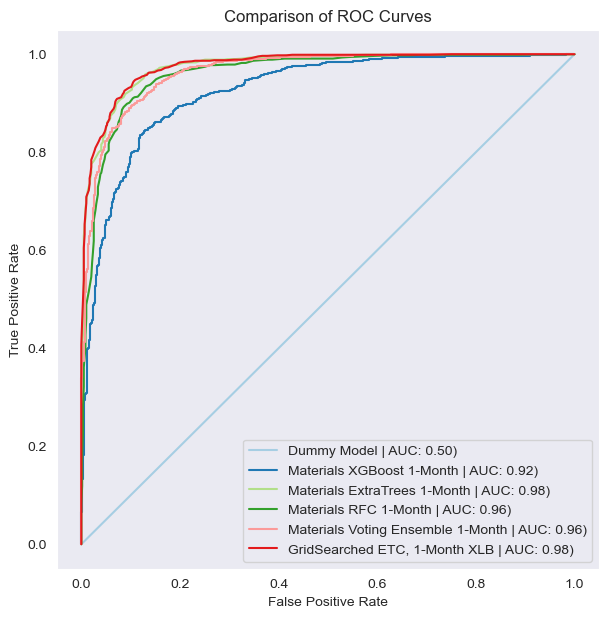

In [60]:
# Plotting the top models vs the dummy
compare_curves([dummy1, XGBoost, etc, rfc, votingC, gridS_cv])

### Final Observations
The difference of 0.001 in ccp_alpha allowed for an improvement on our best model of 0.2% total but NEARLY 5% OVERALL between different GridSearchCV best_estimators_. I find these results fascinating, and they also serve as a reminder than very minute changes can result in outsized changes in performance.

In [63]:
# Extracting feature importances and adding them to a dataframe to contain them for each model

features = list(gridS_cv.model.get_params()["ct"].get_feature_names_out())
features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]

imp_feats = gridS_cv.model.get_params()['model'].feature_importances_

imp_list = list(zip(features_list, imp_feats))
imp_dict = dict(imp_list)

Importance(imp_dict)
Importance.df.rename(index={0:"1 Month XLB"}, inplace=True)

print("Top 5 Feature Importances")
for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:5]:
    print(i)

Top 5 Feature Importances
('20_day_SMA', 0.05458984040859659)
('MACD', 0.05336703725587483)
('lower_bollinger_band', 0.053166315213548525)
('lowest_bollinger_band', 0.05298822022809901)
('ATR', 0.052782983016137576)


,Interest Rates,GDP,ATR,lowest_bollinger_band,MACD,lower_bollinger_band,upper_bollinger_band,20_day_SMA,one_up_bollinger_band,Close,High,Adj Close,Low,RSI,Open,dollar_volume(M),Volume,garman_klass_vol,SMB,CMA,HML,RMW,Mkt-RF,Quarter_1,Quarter_2,Quarter_3,Quarter_4,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4
1 Month XLB,0.052312,0.026385,0.052783,0.052988,0.053367,0.053166,0.050207,0.05459,0.051651,0.049915,0.046586,0.048623,0.047186,0.044443,0.041953,0.024971,0.024999,0.029226,0.018022,0.01818,0.018712,0.018992,0.017569,0.014466,0.01395,0.012738,0.01292,0.01084,0.01112,0.015179,0.011959


In [64]:
def features_from_trees(model_class):

    # Extracting feature importances and adding them to a dataframe to contain them for each model

    features = list(model_class.model.get_params()["ct"].get_feature_names_out())
    features_list = [i.replace("num_pipe__", "").replace("cat_pipe__","") for i in features]

    imp_feats = model_class.model.get_params()['model'].feature_importances_

    imp_list = list(zip(features_list, imp_feats))
    imp_dict = dict(imp_list)

    Importance(imp_dict)

    print("Top 5 Feature Importances")
    for i in sorted(imp_list, key=lambda x: x[1], reverse=True)[:5]:
        print(i)

<hr style="border: 2px solid royalblue">

# Cells to model all of the data

In [140]:
# Iterations -> choose time horizon in the function arguments

X_train, X_test, y_train, y_test = select_data(materials_df, "Twelve")


# Dummy Classifier for new time horizon
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)


# CHANGE THE CLASS EACH TIME IT'S APPROPRIATE
dummy3 = Materials("Dummy Materials 12-Month", dummy, X_train, X_test, y_train, y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished


In [142]:
Materials.model_df.iloc[17:]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
17,Dummy Materials 6-Month,0.680205,0.680205,1.000000,0.809669,11.526568,0.678715,0.678715,1.000000,0.808612,11.580290,0.500000
18,Materials Logistic Regression 6-Month,0.754515,0.786643,0.876970,0.829347,0.501824,0.737617,0.779676,0.855030,0.815616,0.512208,0.782758
19,Materials RFC 6-Month,0.949118,0.954930,0.971130,0.962910,0.166806,0.951138,0.953713,0.975345,0.964408,0.142219,0.987817
20,Materials ExtraTrees 6-Month,0.956705,0.963759,0.973099,0.968345,0.128323,0.963855,0.966019,0.981262,0.973581,0.151845,0.990050
21,Materials XGBoost 6-Month,0.934611,0.943459,0.961613,0.952417,0.188181,0.948461,0.954413,0.970414,0.962347,0.153826,0.985421
22,"GridSearched ETC, 6-Month XLB",0.956705,0.963759,0.973099,0.968345,0.128323,0.963855,0.966019,0.981262,0.973581,0.151845,0.990050
23,Dummy Materials 12-Month,0.702075,0.702075,1.000000,0.824964,10.738292,0.713521,0.713521,1.000000,0.832812,10.325759,0.500000


In [125]:
# Algorithms

# LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
# fit_intercept=True)

# RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
#                                   min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
#                                   max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
#                                   oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)

# ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
#     min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
#     bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
#     ccp_alpha=0.0, max_samples=None)
 

#     XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
#                          tree_method="auto", n_jobs=4, random_state=13)

model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
                         tree_method="auto", n_jobs=4, random_state=13)
    
    )])

model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fddad77b460>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=1.0,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=0,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=4, num_parallel_tree=None, predictor=None,
                               random_state=13, ...))])

In [127]:
# logreg2 = Materials("Materials Logistic Regression 6-Month", model_pipe, X_train, X_test, y_train, y_test)
# rfc2 = Materials("Materials RFC 6-Month", model_pipe, X_train, X_test, y_train, y_test)
# etc2 = Materials("Materials ExtraTrees 6-Month", model_pipe, X_train, X_test, y_train, y_test)
# XGBoost2 = Materials("Materials XGBoost 6-Month", model_pipe, X_train, X_test, y_train, y_test)

Materials.model_df.iloc[17:].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
20,Materials ExtraTrees 6-Month,0.956705,0.963759,0.973099,0.968345,0.128323,0.963855,0.966019,0.981262,0.973581,0.151845,0.990050
19,Materials RFC 6-Month,0.949118,0.954930,0.971130,0.962910,0.166806,0.951138,0.953713,0.975345,0.964408,0.142219,0.987817
21,Materials XGBoost 6-Month,0.934611,0.943459,0.961613,0.952417,0.188181,0.948461,0.954413,0.970414,0.962347,0.153826,0.985421
18,Materials Logistic Regression 6-Month,0.754515,0.786643,0.876970,0.829347,0.501824,0.737617,0.779676,0.855030,0.815616,0.512208,0.782758
17,Dummy Materials 6-Month,0.680205,0.680205,1.000000,0.809669,11.526568,0.678715,0.678715,1.000000,0.808612,11.580290,0.500000


### Editorial Discretion
From here forward, I will not be using KNN or AdaBoost as they are not performing well on any of the data I have used them on thus far. I will keep using logisitc regression only because I find it very interesting to compare the performance of parametric models to tree based algorithms. I also will not use the voting or stacking ensembles, however, I will continue to use GridSearchCV

In [130]:
# Parameters to search through

params = {"model__criterion": ['gini', 'entropy', 'log_loss'],
         'model__max_depth': [None, 7, 5],
         'model__max_features': ["auto", "sqrt", "log2"],
         "model__ccp_alpha": [0, .001, .01, .1],
         }


# Fitting the gridsearch model 

grid = GridSearchCV(estimator=etc2.model, param_grid=params, n_jobs=6, verbose=1)
grid.fit(X_train, y_train)

# Adding GridSearchCV searched model

# gridS_cv2 = Materials("GridSearched ETC, 6-Month XLB", grid.best_estimator_, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.2s finished


In [131]:
Materials.model_df.iloc[17:].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
20,Materials ExtraTrees 6-Month,0.956705,0.963759,0.973099,0.968345,0.128323,0.963855,0.966019,0.981262,0.973581,0.151845,0.990050
22,"GridSearched ETC, 6-Month XLB",0.956705,0.963759,0.973099,0.968345,0.128323,0.963855,0.966019,0.981262,0.973581,0.151845,0.990050
19,Materials RFC 6-Month,0.949118,0.954930,0.971130,0.962910,0.166806,0.951138,0.953713,0.975345,0.964408,0.142219,0.987817
21,Materials XGBoost 6-Month,0.934611,0.943459,0.961613,0.952417,0.188181,0.948461,0.954413,0.970414,0.962347,0.153826,0.985421
18,Materials Logistic Regression 6-Month,0.754515,0.786643,0.876970,0.829347,0.501824,0.737617,0.779676,0.855030,0.815616,0.512208,0.782758
17,Dummy Materials 6-Month,0.680205,0.680205,1.000000,0.809669,11.526568,0.678715,0.678715,1.000000,0.808612,11.580290,0.500000


In [138]:
# Add the feature importances

# features_from_trees(etc2)

# Rename the columns
# Importance.df.rename(index={2:"6-Month XLB"}, inplace=True)

# View the dataframe 
Importance.df.T

,1 Month XLB,3-Month XLB,6-Month XLB
Interest Rates,0.052312,0.061072,0.069081
GDP,0.026385,0.043874,0.063467
ATR,0.052783,0.046875,0.038258
lowest_bollinger_band,0.052988,0.051249,0.043724
MACD,0.053367,0.037728,0.028130
...,...,...,...
Quarter_4,0.012920,0.024063,0.030743
cycle_year_1,0.010840,0.022528,0.026395
cycle_year_2,0.011120,0.018522,0.026992
cycle_year_3,0.015179,0.025083,0.037252


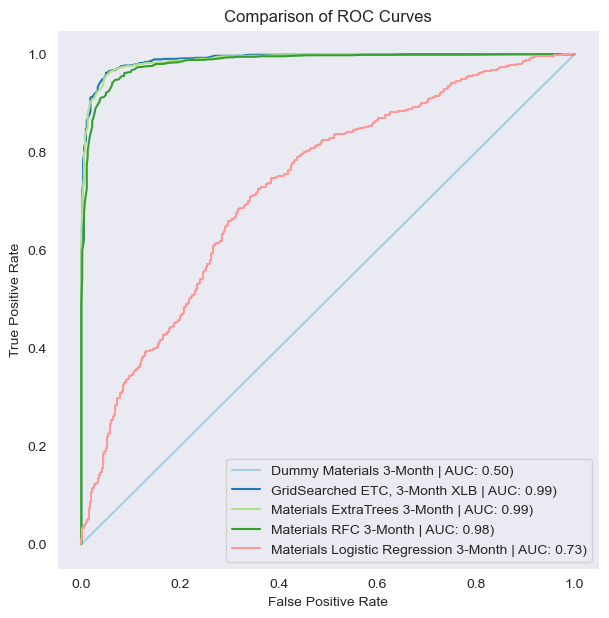

In [114]:
# Gridsearch Model Best Model

compare_curves([dummy1, gridS_cv1, etc1, rfc1, logreg1])

<hr style="border: 4px solid green">

# Functions to speed everything up

In [215]:
def dummy_model(model_type, sector_name, time_period):
    # Dummy Classifier for new time horizon
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)


    # CHANGE THE CLASS EACH TIME IT'S APPROPRIATE
    return model_type(f"Dummy {sector_name} {str(time_period)}-Month", dummy, X_train, X_test, y_train, y_test)

In [139]:
def l_regr(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", LogisticRegression(n_jobs=4, verbose=0, random_state=13, solver='lbfgs', max_iter=100, C=1, tol=0.0001, \
                                    fit_intercept=True)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Logistic Regression {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)
    

In [155]:
def r_forest(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2,\
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features="sqrt",\
                                  max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True,\
                                  oob_score=False, n_jobs=4, random_state=13, verbose=0, class_weight=None)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Random Forest {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)
    

In [156]:
def extra_trees(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, \
    min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, \
    bootstrap=False,oob_score=False, n_jobs=None, random_state=13, verbose=0, warm_start=False, class_weight=None, \
    ccp_alpha=0.0, max_samples=None)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} Extra Trees {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)
    

In [162]:
def x_g_b(model_type, sector_name, time_period):
    model_pipe = Pipeline(steps=[
    ("ct", ct),
    ("model", XGBClassifier(n_estimators=50, max_depth=None, max_leaves=0, learning_rate=1.0, booster='gbtree',\
                         tree_method="auto", n_jobs=4, random_state=13)
    )])

    model_pipe.fit(X_train, y_train)
    
    return model_type(f"{sector_name} XGBoost {str(time_period)}-Month", model_pipe,\
                     X_train, X_test, y_train, y_test)
    

In [299]:
def best_etc_grid(estimator, model_type, sector_name, time_period):
    # Parameters to search through

    params = {"model__criterion": ['gini', 'entropy', 'log_loss'],
             'model__max_depth': [None, 7, 5],
             'model__max_features': ["auto", "sqrt", "log2"],
             "model__ccp_alpha": [0, .001, .01, .1],
         }


# Fitting the gridsearch model 

    grid = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=6, verbose=1)
    grid.fit(X_train, y_train)

# Adding GridSearchCV searched model
    print(grid.best_params_)

    return model_type(f"GridSearched Best-Model, {time_period}-Month {sector_name}",\
                      grid.best_estimator_, X_train, X_test, y_train, y_test)

### Object creations and dataframes

In [219]:
# logreg3 = l_regr(Materials, "Materials", 12)
# rfc3 = r_forest(Materials, "Materials", 12)
# etc3 = extra_trees(Materials, "Materials", 12)
# XGBoost3 = x_g_b(Materials, "Materials", 12)
# best_etc_grid(estimator=etc3.model, model_type=Materials, sector_name="Materials", time_period=12)

Materials.model_df.iloc[23:]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,Dummy Materials 12-Month,0.702075,0.702075,1.000000,0.824964,10.738292,0.713521,0.713521,1.000000,0.832812,10.325759,0.500000
24,Materials Logistic Regression 12-Month,0.826599,0.848401,0.917034,0.881306,0.389448,0.846051,0.873882,0.916510,0.894689,0.373387,0.884021
26,Materials Random Forest 12-Month,0.971659,0.979679,0.979976,0.979821,0.087653,0.975904,0.984934,0.981238,0.983083,0.117441,0.994878
27,Materials Extra Trees 12-Month,0.979024,0.987252,0.982836,0.985032,0.069167,0.981928,0.987793,0.986867,0.987330,0.095225,0.996001
25,Materials XGBoost 12-Month,0.969429,0.978383,0.978071,0.978221,0.092013,0.973226,0.981238,0.981238,0.981238,0.083920,0.994275
28,"GridSearched PIPELINE(STEPS=[('CT',\n ...",0.979024,0.986948,0.983155,0.985039,0.060795,0.985274,0.990602,0.988743,0.989671,0.092646,0.996232


<hr style="border: 3px solid hotpink">

# From here forward: (Materials Completed)
I will be using every function that I have created to abbreviate and expedite the process of iterating through models in different sectors. The markdown explanations will be extremely sparse, but I will summarize the findings at the end of the notebook.

In [216]:
# Create variables

X_train, X_test, y_train, y_test = select_data(energy_df, "One")

In [228]:
# Create Model Objects

# dummy_E = dummy_model(Energy, "Energy", 1)
# logreg3 = l_regr(Energy, "Energy", 1)
# rfc3 = r_forest(Energy, "Energy", 1)
# etc3 = extra_trees(Energy, "Energy", 1)
# XGBoost3 = x_g_b(Energy, "Energy", 1)
# grid = best_etc_grid(estimator=etc3.model, model_type=Energy, sector_name="Energy", time_period=1)

Energy.model_df.sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
5,"GridSearched Best-Model, 1-Month Energy",0.906715,0.914735,0.923315,0.918987,0.271652,0.914993,0.928656,0.920991,0.924808,0.239967,0.969846
3,Energy Extra Trees 1-Month,0.905601,0.913060,0.923317,0.918089,0.266331,0.914324,0.925532,0.923349,0.924439,0.264940,0.969174
2,Energy Random Forest 1-Month,0.884398,0.884228,0.918643,0.901070,0.348565,0.890228,0.891304,0.918632,0.904762,0.323588,0.953783
4,Energy XGBoost 1-Month,0.837532,0.849890,0.870382,0.859845,0.435341,0.845382,0.858304,0.871462,0.864833,0.417102,0.911323
1,Energy Logistic Regression 1-Month,0.569291,0.584381,0.861042,0.696187,0.677679,0.570281,0.580595,0.875000,0.698024,0.674558,0.576213
0,Dummy Energy 1-Month,0.573310,0.573310,1.000000,0.728794,15.379481,0.567604,0.567604,1.000000,0.724167,15.585141,0.500000


In [232]:
# Best 1 Month XLE model, ETC, 

Energy.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ca90970>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ca90b20>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, criterion='entropy',
                                      random_state=13))])

In [272]:
features_from_trees(Energy.model_list[5])

Top 5 Feature Importances
('upper_bollinger_band', 0.05368648019187214)
('one_up_bollinger_band', 0.051792827923742894)
('20_day_SMA', 0.05159313689185975)
('Interest Rates', 0.05091009702493961)
('ATR', 0.05084908408024863)


<hr style="border: 2px solid darkgreen">

# XLE 3 Month

In [242]:
# Create variables

X_train, X_test, y_train, y_test = select_data(energy_df, "Three")

# Create Model Objects

# dummy_E_3month = dummy_model(Energy, "Energy", 3)
# logregE_3month = l_regr(Energy, "Energy", 3)
# rfcE_3month = r_forest(Energy, "Energy", 3)
# etcE_3month = extra_trees(Energy, "Energy", 3)
# XGBoostE_3month = x_g_b(Energy, "Energy", 3)
# grid_E_3month = best_etc_grid(estimator=etcE_3month.model, model_type=Energy, sector_name="Energy", time_period=3)

Energy.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,Energy Extra Trees 3-Month,0.943763,0.948564,0.961372,0.954760,0.186474,0.945783,0.950362,0.965336,0.957791,0.245627,0.980959
11,"GridSearched Best-Model, 3-Month Energy",0.943986,0.950195,0.959928,0.954890,0.185371,0.945783,0.950362,0.965336,0.957791,0.242754,0.981446
8,Energy Random Forest 3-Month,0.931042,0.931783,0.958845,0.944995,0.230944,0.939090,0.940635,0.965336,0.952825,0.221963,0.976660
10,Energy XGBoost 3-Month,0.912965,0.921410,0.939711,0.930315,0.257310,0.930388,0.940748,0.950630,0.945664,0.216797,0.968157
7,Energy Logistic Regression 3-Month,0.656328,0.671009,0.871119,0.758028,0.629548,0.654618,0.682274,0.857143,0.759777,0.629924,0.628122
6,Dummy Energy 3-Month,0.618166,0.618166,1.000000,0.764033,13.762703,0.637216,0.637216,1.000000,0.778414,13.076078,0.500000


In [241]:
Energy.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ca76ef0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ca75f30>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, criterion='entropy',
                                      random_state=13))])

In [273]:
features_from_trees(etcE_3month)

Top 5 Feature Importances
('GDP', 0.052437333006913105)
('Interest Rates', 0.05107856360994236)
('ATR', 0.05101059343781691)
('Close', 0.048154397996280664)
('one_up_bollinger_band', 0.04785352057468764)


<hr style="border: 2px solid darkgreen">

# XLE 6 Month

In [247]:
# Create variables

X_train, X_test, y_train, y_test = select_data(energy_df, "Six")

# Create Model Objects

# dummy_E_6month = dummy_model(Energy, "Energy", 6)
# logregE_6month = l_regr(Energy, "Energy", 6)
# rfcE_6month = r_forest(Energy, "Energy", 6)
# etcE_6month = extra_trees(Energy, "Energy", 6)
# XGBoostE_6month = x_g_b(Energy, "Energy", 6)
# grid_E_6month = best_etc_grid(estimator=etcE_6month.model, model_type=Energy, sector_name="Energy", time_period=6)

Energy.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,Energy Extra Trees 6-Month,0.964739,0.975521,0.969359,0.972410,0.133980,0.968541,0.974950,0.977889,0.976417,0.093572,0.995605
17,"GridSearched Best-Model, 6-Month Energy",0.964739,0.975521,0.969359,0.972410,0.133980,0.968541,0.974950,0.977889,0.976417,0.093572,0.995605
14,Energy Random Forest 6-Month,0.956706,0.961201,0.971798,0.966432,0.150002,0.962517,0.967164,0.976884,0.972000,0.124439,0.993174
16,Energy XGBoost 6-Month,0.950456,0.956671,0.966574,0.961566,0.154574,0.957162,0.970677,0.964824,0.967742,0.131171,0.989625
13,Energy Logistic Regression 6-Month,0.702295,0.724345,0.864550,0.788176,0.582109,0.718876,0.747206,0.873367,0.805375,0.553952,0.749046
12,Dummy Energy 6-Month,0.640928,0.640928,1.000000,0.781178,12.942254,0.665997,0.665997,1.000000,0.799518,12.038677,0.500000


In [248]:
Energy.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff2b010>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff2b5e0>)])),
                ('model', ExtraTreesClassifier(ccp_alpha=0, random_state=13))])

In [274]:
features_from_trees(etcE_6month)

Top 5 Feature Importances
('Interest Rates', 0.06301455201473098)
('GDP', 0.05726202938951708)
('cycle_year_1', 0.05250673624849346)
('one_up_bollinger_band', 0.04793527541906699)
('High', 0.046298582326515465)


<hr style="border: 2px solid darkgreen">

# XLE 12 Month

In [253]:
# Create variables

X_train, X_test, y_train, y_test = select_data(energy_df, "Twelve")

# Create Model Objects

# dummy_E_12month = dummy_model(Energy, "Energy", 12)
# logregE_12month = l_regr(Energy, "Energy", 12)
# rfcE_12month = r_forest(Energy, "Energy", 12)
# etcE_12month = extra_trees(Energy, "Energy", 12)
# XGBoostE_12month = x_g_b(Energy, "Energy", 12)
# grid_E_12month = best_etc_grid(estimator=etcE_12month.model, model_type=Energy, sector_name="Energy", time_period=12)

Energy.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Energy Extra Trees 12-Month,0.979468,0.982168,0.986812,0.984482,0.068770,0.980589,0.981299,0.990070,0.985665,0.055483,0.998220
23,"GridSearched Best-Model, 12-Month Energy",0.980361,0.983175,0.987150,0.985152,0.063432,0.980589,0.982249,0.989076,0.985651,0.056005,0.998331
20,Energy Random Forest 12-Month,0.974559,0.977501,0.984106,0.980788,0.076852,0.976573,0.978346,0.987090,0.982699,0.071217,0.997273
22,Energy XGBoost 12-Month,0.970987,0.974820,0.981399,0.978094,0.087563,0.971888,0.973503,0.985104,0.979269,0.083846,0.996035
19,Energy Logistic Regression 12-Month,0.750059,0.785507,0.854934,0.818627,0.482815,0.761714,0.790366,0.879841,0.832707,0.482334,0.811125
18,Dummy Energy 12-Month,0.659897,0.659897,1.000000,0.795106,12.258543,0.674029,0.674029,1.000000,0.805278,11.749169,0.500000


In [254]:
Energy.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff44070>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff46b90>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, max_features='log2',
                                      random_state=13))])

In [268]:
features_from_trees(etcE_12month)

Top 5 Feature Importances
('GDP', 0.07522481766987556)
('cycle_year_1', 0.07221423182614486)
('Interest Rates', 0.06943491706314846)
('upper_bollinger_band', 0.05817484513436159)
('one_up_bollinger_band', 0.053645824307485546)


<hr style="border: 2px solid black">

#  Financials

### 1 Month

In [259]:
# Create variables

X_train, X_test, y_train, y_test = select_data(financial_df, "One")


# Create Model Objects

# dummy_F_1 = dummy_model(Financials, "Financials", 1)
# logreg_F_1 = l_regr(Financials, "Financials", 1)
# rfc_F_1 = r_forest(Financials, "Financials", 1)
# etc_F_1 = extra_trees(Financials, "Financials", 1)
# XGBoost_F_1 = x_g_b(Financials, "Financials", 1)
# grid_F_1 = best_etc_grid(estimator=etc_F_1.model, model_type=Financials, sector_name="Financials", time_period=1)

Financials.model_df.sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
5,"GridSearched Best-Model, 1-Month Financials",0.901805,0.906743,0.929831,0.918047,0.296365,0.906961,0.897175,0.942993,0.919514,0.250673,0.966124
3,Financials Extra Trees 1-Month,0.897342,0.904775,0.923797,0.914108,0.292521,0.903614,0.892135,0.942993,0.916859,0.254558,0.964967
2,Financials Random Forest 1-Month,0.881724,0.884225,0.920782,0.902049,0.336429,0.888220,0.869660,0.942993,0.904843,0.312444,0.956921
4,Financials XGBoost 1-Month,0.842667,0.850293,0.890978,0.870137,0.429029,0.854083,0.847439,0.903800,0.874713,0.409302,0.919327
1,Financials Logistic Regression 1-Month,0.611017,0.634406,0.808744,0.710979,0.649589,0.569612,0.586297,0.802850,0.677694,0.672305,0.602338
0,Dummy Financials 1-Month,0.591609,0.591609,1.000000,0.743410,14.719906,0.563588,0.563588,1.000000,0.720890,15.729894,0.500000


In [263]:
# Best 1 Month XLF model, ETC, entropy instead of gini 

grid_F_1.model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ca76740>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ca768f0>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, criterion='entropy',
                                      random_state=13))])

In [276]:
features_from_trees(grid_F_1)

Top 5 Feature Importances
('MACD', 0.054892682089712756)
('one_up_bollinger_band', 0.052938585135503057)
('Interest Rates', 0.05126763994635122)
('20_day_SMA', 0.0511962338254857)
('lower_bollinger_band', 0.05106692894609968)


<hr style="border: 2px solid darkgreen">

# XLF 3 Month

In [267]:
# Create variables

X_train, X_test, y_train, y_test = select_data(financial_df, "Three")


# Create Model Objects

# dummy_F_3 = dummy_model(Financials, "Financials", 3)
# logreg_F_3 = l_regr(Financials, "Financials", 3)
# rfc_F_3 = r_forest(Financials, "Financials", 3)
# etc_F_3 = extra_trees(Financials, "Financials", 3)
# XGBoost_F_3 = x_g_b(Financials, "Financials", 3)
# grid_F_3 = best_etc_grid(estimator=etc_F_3.model, model_type=Financials, sector_name="Financials", time_period=3)

Financials.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,Financials Extra Trees 3-Month,0.950012,0.954636,0.967888,0.961184,0.175862,0.939090,0.949588,0.956477,0.953020,0.153060,0.986479
11,"GridSearched Best-Model, 3-Month Financials",0.950012,0.954636,0.967888,0.961184,0.175862,0.939090,0.949588,0.956477,0.953020,0.153060,0.986479
8,Financials Random Forest 3-Month,0.939301,0.942077,0.964398,0.953099,0.221352,0.933066,0.935549,0.962694,0.948927,0.192917,0.981622
10,Financials XGBoost 3-Month,0.920555,0.925426,0.952531,0.938775,0.255015,0.915663,0.925888,0.945078,0.935385,0.243422,0.968669
7,Financials Logistic Regression 3-Month,0.699398,0.723381,0.857941,0.784851,0.564090,0.694110,0.721640,0.856995,0.783515,0.575785,0.710560
6,Dummy Financials 3-Month,0.639366,0.639366,1.000000,0.780016,12.998555,0.645917,0.645917,1.000000,0.784872,12.762445,0.500000


In [241]:
Energy.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ca76ef0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ca75f30>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, criterion='entropy',
                                      random_state=13))])

In [277]:
features_from_trees(etc_F_3)

Top 5 Feature Importances
('Interest Rates', 0.06173866096177341)
('GDP', 0.05682462471491224)
('ATR', 0.05051481564303867)
('20_day_SMA', 0.04748049387688254)
('one_up_bollinger_band', 0.04747224745300139)


<hr style="border: 2px solid darkgreen">

# XLF 6 Month

In [281]:
# Create variables

X_train, X_test, y_train, y_test = select_data(financial_df, "Six")

# Create Model Objects

# dummy_F_6month = dummy_model(Financials, "Financials", 6)
# logreg_F_6month = l_regr(Financials, "Financials", 6)
# rfc_F_6month = r_forest(Financials, "Financials", 6)
# etc_F_6month = extra_trees(Financials, "Financials", 6)
# XGBoost_F_6month = x_g_b(Financials, "Financials", 6)
# grid_F_6month = best_etc_grid(estimator=etc_F_6month.model, model_type=Financials, sector_name="Financials", time_period=6)

Financials.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,Financials Extra Trees 6-Month,0.963849,0.970263,0.972963,0.971603,0.140160,0.971888,0.980573,0.976578,0.978571,0.089501,0.995073
14,Financials Random Forest 6-Month,0.959161,0.963197,0.972963,0.968048,0.163318,0.968541,0.976555,0.975560,0.976057,0.116501,0.992725
17,"GridSearched Best-Model, 6-Month Financials",0.966081,0.972665,0.974018,0.973337,0.158959,0.968541,0.979487,0.972505,0.975984,0.088414,0.995424
16,Financials XGBoost 6-Month,0.950012,0.955265,0.966642,0.960909,0.154134,0.950469,0.969979,0.954175,0.962012,0.157690,0.986354
13,Financials Logistic Regression 6-Month,0.693595,0.722192,0.841648,0.777352,0.532742,0.704150,0.742370,0.842159,0.789122,0.524029,0.770993
12,Dummy Financials 6-Month,0.635572,0.635572,1.000000,0.777186,13.135301,0.657296,0.657296,1.000000,0.793215,12.352310,0.500000


In [282]:
Energy.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff44070>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff46b90>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, max_features='log2',
                                      random_state=13))])

In [283]:
features_from_trees(etc_F_6month)

Top 5 Feature Importances
('GDP', 0.08348138224905939)
('Interest Rates', 0.07139984058692139)
('garman_klass_vol', 0.05044318038433828)
('upper_bollinger_band', 0.048443102663826884)
('cycle_year_3', 0.047609285465191775)


<hr style="border: 2px solid darkgreen">

# XLF 12 Month

In [286]:
# Create variables

X_train, X_test, y_train, y_test = select_data(financial_df, "Twelve")

# Create Model Objects

# dummy_F_12month = dummy_model(Financials, "Financials", 12)
# logreg_F_12month = l_regr(Financials, "Financials", 12)
# rfc_F_12month = r_forest(Financials, "Financials", 12)
# etc_F_12month = extra_trees(Financials, "Financials", 12)
# XGBoost_F_12month = x_g_b(Financials, "Financials", 12)
# grid_F_12month = best_etc_grid(estimator=etc_F_12month.model, model_type=Financials, sector_name="Financials", time_period=12)

Financials.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Financials",0.979469,0.983879,0.983866,0.983857,0.065058,0.981928,0.987368,0.984260,0.985812,0.053268,0.998809
21,Financials Extra Trees 12-Month,0.979023,0.981827,0.985269,0.983537,0.066500,0.981258,0.987355,0.983211,0.985279,0.055513,0.998686
22,Financials XGBoost 12-Month,0.967866,0.974769,0.974749,0.974721,0.095076,0.979250,0.985263,0.982162,0.983710,0.066435,0.997269
20,Financials Random Forest 12-Month,0.972776,0.978630,0.978609,0.978597,0.094470,0.977912,0.986258,0.979014,0.982622,0.081450,0.997924
19,Financials Logistic Regression 12-Month,0.727744,0.756920,0.842867,0.797515,0.508504,0.726238,0.756121,0.842602,0.797022,0.513921,0.787049
18,Dummy Financials 12-Month,0.636242,0.636242,1.000000,0.777687,13.111173,0.637885,0.637885,1.000000,0.778913,13.051952,0.500000


In [287]:
Energy.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff44070>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff46b90>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, max_features='log2',
                                      random_state=13))])

In [288]:
features_from_trees(grid_F_12month)

Top 5 Feature Importances
('GDP', 0.08598018948668566)
('cycle_year_3', 0.05450946824046702)
('Interest Rates', 0.0531440477907691)
('High', 0.050724320674745964)
('ATR', 0.04831057161826705)


In [293]:
Importance.df[-4:]

,Interest Rates,GDP,ATR,lowest_bollinger_band,MACD,lower_bollinger_band,upper_bollinger_band,20_day_SMA,one_up_bollinger_band,Close,High,Adj Close,Low,RSI,Open,dollar_volume(M),Volume,garman_klass_vol,SMB,CMA,HML,RMW,Mkt-RF,Quarter_1,Quarter_2,Quarter_3,Quarter_4,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4
1_Month XLF,0.051268,0.027116,0.048282,0.050807,0.054893,0.051067,0.048591,0.051196,0.052939,0.047414,0.047261,0.047386,0.045973,0.046175,0.042910,0.026775,0.026074,0.027701,0.017969,0.016996,0.018014,0.017904,0.018444,0.019171,0.020273,0.018431,0.014229,0.009729,0.011457,0.012276,0.011282
3_Month XLF,0.061739,0.056825,0.050515,0.047459,0.031754,0.046741,0.044379,0.047480,0.047472,0.044784,0.044737,0.044204,0.041938,0.026451,0.036606,0.026106,0.024689,0.039932,0.009182,0.009464,0.010870,0.009156,0.009545,0.033909,0.021708,0.015899,0.023928,0.027054,0.019469,0.026155,0.019852
6_Month XLF,0.071400,0.083481,0.045257,0.044191,0.019911,0.042097,0.048443,0.045647,0.043348,0.042221,0.043175,0.042385,0.041744,0.017479,0.036605,0.022406,0.025946,0.050443,0.006408,0.006153,0.006672,0.006795,0.007024,0.021919,0.009928,0.015971,0.025676,0.027643,0.024053,0.047609,0.027972
12_Month XLF,0.053144,0.085980,0.048311,0.046860,0.019388,0.046661,0.042356,0.046701,0.047509,0.044323,0.050724,0.042798,0.043595,0.015423,0.045256,0.017020,0.017738,0.038295,0.005098,0.004860,0.005413,0.004913,0.005180,0.026217,0.015589,0.018252,0.028817,0.024407,0.023043,0.054509,0.031620


<hr style="border: 2px solid black">

#  Industrials

### 1 Month

In [298]:
# Create variables

X_train, X_test, y_train, y_test = select_data(industrial_df, "One")


# Create Model Objects

# dummy_Ind_1 = dummy_model(Industrials, "Industrials", 1)
# logreg_Ind_1 = l_regr(Industrials, "Industrials", 1)
# rfc_Ind_1 = r_forest(Industrials, "Industrials", 1)
# etc_Ind_1 = extra_trees(Industrials, "Industrials", 1)
# XGBoost_Ind_1 = x_g_b(Industrials, "Industrials", 1)
# grid_Ind_1 = best_etc_grid(estimator=etc_Ind_1.model, model_type=Industrials, sector_name="Industrials", time_period=1)

Industrials.model_df.sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
3,Industrials Extra Trees 1-Month,0.904709,0.913811,0.928476,0.921026,0.267587,0.903614,0.915939,0.926049,0.920966,0.237614,0.970812
5,"GridSearched Best-Model, 1-Month Industrials",0.906272,0.917412,0.926984,0.922123,0.270895,0.902276,0.908602,0.932671,0.920479,0.241766,0.970236
2,Industrials Random Forest 1-Month,0.882394,0.888948,0.918416,0.903391,0.336680,0.895582,0.904095,0.926049,0.914940,0.304753,0.955447
4,Industrials XGBoost 1-Month,0.838653,0.851814,0.884508,0.867800,0.433614,0.854083,0.871490,0.890728,0.881004,0.378071,0.922698
1,Industrials Logistic Regression 1-Month,0.643155,0.659257,0.836437,0.737327,0.637355,0.638554,0.662522,0.823400,0.734252,0.633368,0.657615
0,Dummy Industrials 1-Month,0.598974,0.598974,1.000000,0.749197,14.454460,0.606426,0.606426,1.000000,0.755000,14.185856,0.500000


In [301]:
# Best 1 Month XLF model, ETC, entropy instead of gini 

Industrials.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fddba5681c0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fddba56b4f0>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, criterion='entropy',
                                      max_features='log2', random_state=13))])

In [302]:
features_from_trees(etc_Ind_1)

Top 5 Feature Importances
('lower_bollinger_band', 0.05509461777649369)
('20_day_SMA', 0.05476047166074134)
('MACD', 0.05400624575445631)
('lowest_bollinger_band', 0.05276820671744751)
('upper_bollinger_band', 0.052674315630247354)


<hr style="border: 2px solid darkgreen">

# XLI 3 Month

In [306]:
# Create variables

X_train, X_test, y_train, y_test = select_data(industrial_df, "Three")


# Create Model Objects

# dummy_Ind_3 = dummy_model(Industrials, "Industrials", 3)
# logreg_Ind_3 = l_regr(Industrials, "Industrials", 3)
# rfc_Ind_3 = r_forest(Industrials, "Industrials", 3)
# etc_Ind_3 = extra_trees(Industrials, "Industrials", 3)
# XGBoost_Ind_3 = x_g_b(Industrials, "Industrials", 3)
# grid_Ind_3 = best_etc_grid(estimator=etc_Ind_3.model, model_type=Industrials, sector_name="Industrials", time_period=3)

Industrials.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,Industrials Extra Trees 3-Month,0.941529,0.953501,0.957396,0.955430,0.177774,0.950469,0.962777,0.962777,0.962777,0.163352,0.988799
11,"GridSearched Best-Model, 3-Month Industrials",0.943537,0.955205,0.958757,0.956965,0.179734,0.948461,0.961732,0.960765,0.961248,0.144908,0.988728
8,Industrials Random Forest 3-Month,0.935503,0.948264,0.953646,0.950917,0.211156,0.940428,0.950249,0.960765,0.955478,0.208158,0.983018
10,Industrials XGBoost 3-Month,0.919881,0.932927,0.945806,0.939281,0.233205,0.912985,0.933735,0.935614,0.934673,0.248312,0.967956
7,Industrials Logistic Regression 3-Month,0.699845,0.723143,0.877641,0.792920,0.560659,0.710174,0.737913,0.875252,0.800736,0.553918,0.736855
6,Dummy Industrials 3-Month,0.654765,0.654765,1.000000,0.791369,12.443544,0.665328,0.665328,1.000000,0.799035,12.062802,0.500000


In [307]:
Industrials.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ca41600>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fddba487730>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, criterion='entropy',
                                      max_features='log2', random_state=13))])

In [308]:
features_from_trees(etc_Ind_3)

Top 5 Feature Importances
('Interest Rates', 0.06270507808871595)
('GDP', 0.05082391850351781)
('ATR', 0.04695760500553067)
('20_day_SMA', 0.04636888040937872)
('upper_bollinger_band', 0.04606974871828563)


<hr style="border: 2px solid darkgreen">

# XLI 6 Month

In [312]:
# Create variables

X_train, X_test, y_train, y_test = select_data(industrial_df, "Six")


# Create Model Objects

# dummy_Ind_6 = dummy_model(Industrials, "Industrials", 6)
# logreg_Ind_6 = l_regr(Industrials, "Industrials", 6)
# rfc_Ind_6 = r_forest(Industrials, "Industrials", 6)
# etc_Ind_6 = extra_trees(Industrials, "Industrials", 6)
# XGBoost_Ind_6 = x_g_b(Industrials, "Industrials", 6)
# grid_Ind_6 = best_etc_grid(estimator=etc_Ind_6.model, model_type=Industrials, sector_name="Industrials", time_period=6)

Industrials.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
17,"GridSearched Best-Model, 6-Month Industrials",0.966524,0.973307,0.977167,0.975220,0.125311,0.963186,0.974460,0.971596,0.973026,0.103829,0.992892
15,Industrials Extra Trees 6-Month,0.963401,0.969165,0.976836,0.972973,0.123619,0.959839,0.972468,0.968658,0.970559,0.119715,0.993402
14,Industrials Random Forest 6-Month,0.958267,0.964946,0.973527,0.969202,0.142115,0.954485,0.964878,0.968658,0.966764,0.127253,0.990359
16,Industrials XGBoost 6-Month,0.948447,0.955641,0.968560,0.962035,0.157692,0.943106,0.956140,0.960823,0.958476,0.166232,0.985687
13,Industrials Logistic Regression 6-Month,0.761434,0.781783,0.896421,0.835159,0.499220,0.757697,0.785776,0.887365,0.833487,0.492852,0.798452
12,Dummy Industrials 6-Month,0.674403,0.674403,1.000000,0.805544,11.735705,0.683400,0.683400,1.000000,0.811928,11.411411,0.500000


In [313]:
Energy.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff44070>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff46b90>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, max_features='log2',
                                      random_state=13))])

In [314]:
features_from_trees(grid_Ind_6)

Top 5 Feature Importances
('GDP', 0.08263889529658106)
('Interest Rates', 0.07011319670427124)
('High', 0.046677450662670726)
('lower_bollinger_band', 0.046363960838590824)
('Adj Close', 0.0459196245188031)


<hr style="border: 2px solid darkgreen">

# XLI 12 Month

In [318]:
# Create variables

X_train, X_test, y_train, y_test = select_data(industrial_df, "Twelve")


# Create Model Objects

# dummy_Ind_12 = dummy_model(Industrials, "Industrials", 12)
# logreg_Ind_12 = l_regr(Industrials, "Industrials", 12)
# rfc_Ind_12 = r_forest(Industrials, "Industrials", 12)
# etc_Ind_12 = extra_trees(Industrials, "Industrials", 12)
# XGBoost_Ind_12 = x_g_b(Industrials, "Industrials", 12)
# grid_Ind_12 = best_etc_grid(estimator=etc_Ind_12.model, model_type=Industrials, sector_name="Industrials", time_period=12)

Industrials.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Industrials",0.971658,0.976591,0.985586,0.981040,0.103026,0.977912,0.981579,0.989390,0.985469,0.058677,0.997920
20,Industrials Random Forest 12-Month,0.965857,0.972105,0.982282,0.977155,0.132400,0.977242,0.980719,0.989390,0.985035,0.080270,0.996709
21,Industrials Extra Trees 12-Month,0.970319,0.976270,0.984084,0.980131,0.104381,0.977242,0.979878,0.990274,0.985048,0.061131,0.997636
22,Industrials XGBoost 12-Month,0.961840,0.967469,0.981682,0.974513,0.118401,0.971218,0.975524,0.986737,0.981099,0.099156,0.993765
19,Industrials Logistic Regression 12-Month,0.805846,0.825087,0.937538,0.877704,0.411744,0.812584,0.839585,0.930150,0.882550,0.383360,0.871973
18,Dummy Industrials 12-Month,0.743138,0.743138,1.000000,0.852644,9.258251,0.757028,0.757028,1.000000,0.861714,8.757594,0.500000


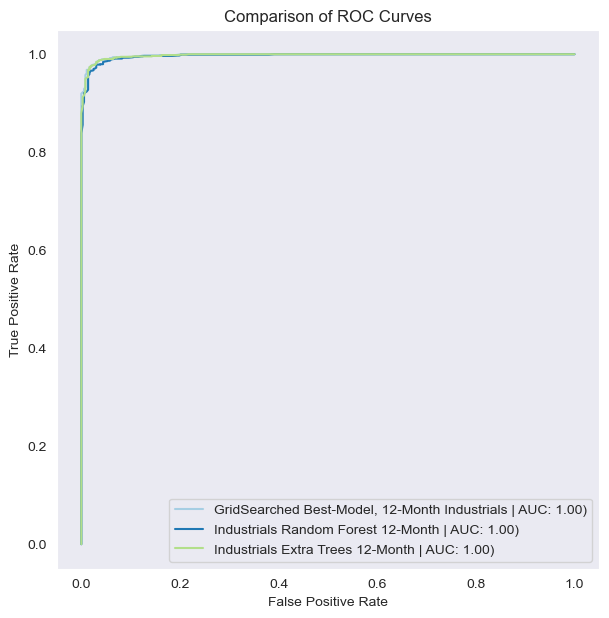

In [323]:
# 3 good models

compare_curves([grid_Ind_12, rfc_Ind_12, etc_Ind_12])

In [325]:
Energy.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff44070>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff46b90>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, max_features='log2',
                                      random_state=13))])

In [326]:
features_from_trees(grid_Ind_12)

Top 5 Feature Importances
('GDP', 0.07828939290643598)
('Interest Rates', 0.07591130441177853)
('ATR', 0.05002640231306067)
('High', 0.04868218694934069)
('garman_klass_vol', 0.04727640161065281)


In [327]:
Importance.df[-4:]

,Interest Rates,GDP,ATR,lowest_bollinger_band,MACD,lower_bollinger_band,upper_bollinger_band,20_day_SMA,one_up_bollinger_band,Close,High,Adj Close,Low,RSI,Open,dollar_volume(M),Volume,garman_klass_vol,SMB,CMA,HML,RMW,Mkt-RF,Quarter_1,Quarter_2,Quarter_3,Quarter_4,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4
12,0.051640,0.025587,0.052477,0.052768,0.054006,0.055095,0.052674,0.054760,0.052613,0.048563,0.046170,0.050159,0.045668,0.040748,0.044860,0.022692,0.021387,0.026690,0.017052,0.015919,0.016574,0.016607,0.016829,0.018166,0.018370,0.014159,0.015661,0.011158,0.014201,0.014625,0.012118
13,0.062705,0.050824,0.046958,0.045890,0.033936,0.046048,0.046070,0.046369,0.045889,0.041995,0.042471,0.041502,0.044637,0.027866,0.041470,0.017596,0.017586,0.033619,0.010261,0.010410,0.011384,0.010203,0.010176,0.032740,0.026699,0.022781,0.023993,0.021502,0.028839,0.030057,0.027527
14,0.070113,0.082639,0.043515,0.043192,0.023167,0.046364,0.044597,0.045103,0.044820,0.040060,0.046677,0.045920,0.042527,0.021039,0.043589,0.017241,0.018648,0.037509,0.007551,0.008247,0.007622,0.008718,0.007475,0.020165,0.017515,0.017254,0.027493,0.023349,0.028523,0.034009,0.035360
15,0.075911,0.078289,0.050026,0.043386,0.023301,0.046352,0.044430,0.042553,0.045108,0.042011,0.048682,0.040733,0.041590,0.018660,0.039922,0.017660,0.014040,0.047276,0.006404,0.007078,0.007076,0.006965,0.006591,0.023189,0.019265,0.020874,0.016938,0.028078,0.032686,0.030318,0.034606


In [328]:
Importance.df.rename(index={12:"Industrials 1-Month", 13:"Industrials 3-Month", 14:"Industrials 6-Month", \
                            15:"Industrials 12-Month"}, inplace=True)

<hr style="border: 2px solid darkgreen">

#  Technology

### 1 Month

In [333]:
# Create variables

X_train, X_test, y_train, y_test = select_data(tech_df, "One")


# Create Model Objects

# dummy_tech_1 = dummy_model(Technology, "Technology", 1)
# logreg_tech_1 = l_regr(Technology, "Technology", 1)
# rfc_tech_1 = r_forest(Technology, "Technology", 1)
# etc_tech_1 = extra_trees(Technology, "Technology", 1)
# XGBoost_tech_1 = x_g_b(Technology, "Technology", 1)
# grid_tech_1 = best_etc_grid(estimator=etc_tech_1.model, model_type=Technology, \
                            sector_name="Technology", time_period=1)

Technology.model_df.sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
3,Technology Extra Trees 1-Month,0.914084,0.923342,0.937140,0.930150,0.269937,0.919009,0.929825,0.937017,0.933407,0.222208,0.973039
5,"GridSearched Best-Model, 1-Month Technology",0.916091,0.924775,0.938966,0.931790,0.279927,0.916332,0.926696,0.935912,0.931281,0.227693,0.971494
2,Technology Random Forest 1-Month,0.896229,0.899443,0.934579,0.916652,0.315162,0.909639,0.913978,0.939227,0.926431,0.276692,0.965137
4,Technology XGBoost 1-Month,0.851370,0.865302,0.896200,0.880393,0.400305,0.850736,0.874725,0.879558,0.877135,0.392322,0.920902
1,Technology Logistic Regression 1-Month,0.642489,0.654644,0.877928,0.749928,0.642659,0.645917,0.655629,0.875138,0.749645,0.645382,0.630847
0,Dummy Technology 1-Month,0.610578,0.610578,1.000000,0.758210,14.036195,0.605756,0.605756,1.000000,0.754481,14.209981,0.500000


In [334]:
# Best 1 Month XLF model, ETC, entropy instead of gini 

Technology.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fddc8a64bb0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fddc8a64c70>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, criterion='entropy',
                                      max_features='log2', random_state=13))])

In [335]:
features_from_trees(etc_tech_1)

Top 5 Feature Importances
('Interest Rates', 0.05816604818035539)
('ATR', 0.05464772227557461)
('20_day_SMA', 0.05123318038690895)
('one_up_bollinger_band', 0.05097304617565206)
('MACD', 0.05028960139745181)


<hr style="border: 2px solid darkgreen">

# XLK 3 Month

In [338]:
# Create variables

X_train, X_test, y_train, y_test = select_data(tech_df, "Three")


# Create Model Objects

# dummy_tech_3 = dummy_model(Technology, "Technology", 3)
# logreg_tech_3 = l_regr(Technology, "Technology", 3)
# rfc_tech_3 = r_forest(Technology, "Technology", 3)
# etc_tech_3 = extra_trees(Technology, "Technology", 3)
# XGBoost_tech_3 = x_g_b(Technology, "Technology", 3)
# grid_tech_3 = best_etc_grid(estimator=etc_tech_3.model, model_type=Technology, \
#                             sector_name="Technology", time_period=3)

Technology.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
11,"GridSearched Best-Model, 3-Month Technology",0.954922,0.958811,0.974170,0.966398,0.140868,0.979920,0.984095,0.986056,0.985075,0.141874,0.993308
9,Technology Extra Trees 3-Month,0.954029,0.956628,0.975177,0.965784,0.159013,0.976573,0.984016,0.981076,0.982544,0.138792,0.993223
8,Technology Random Forest 3-Month,0.947559,0.950278,0.972158,0.961046,0.180495,0.963855,0.969368,0.977092,0.973214,0.138972,0.990442
10,Technology XGBoost 3-Month,0.932383,0.936947,0.963436,0.949924,0.203432,0.952477,0.957802,0.972112,0.964904,0.134799,0.986647
7,Technology Logistic Regression 3-Month,0.727290,0.742229,0.904393,0.815243,0.565566,0.722892,0.745424,0.892430,0.812330,0.562805,0.717203
6,Dummy Technology 3-Month,0.665253,0.665253,1.000000,0.798981,12.065497,0.672021,0.672021,1.000000,0.803843,11.821546,0.500000


In [339]:
Industrials.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fddaa5d16c0>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fddaa5d11e0>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, criterion='entropy',
                                      random_state=13))])

In [340]:
features_from_trees(grid_tech_3)

Top 5 Feature Importances
('Interest Rates', 0.06861366030211373)
('GDP', 0.05895196387985924)
('ATR', 0.04894833878851669)
('upper_bollinger_band', 0.04863616816382208)
('one_up_bollinger_band', 0.04643168585719664)


<hr style="border: 2px solid darkgreen">

# XLK 6 Month

In [342]:
# Create variables

X_train, X_test, y_train, y_test = select_data(tech_df, "Six")


# Create Model Objects

# dummy_tech_6 = dummy_model(Technology, "Technology", 6)
# logreg_tech_6 = l_regr(Technology, "Technology", 6)
# rfc_tech_6 = r_forest(Technology, "Technology", 6)
# etc_tech_6 = extra_trees(Technology, "Technology", 6)
# XGBoost_tech_6 = x_g_b(Technology, "Technology", 6)
# grid_tech_6 = best_etc_grid(estimator=etc_tech_6.model, model_type=Technology, \
#                             sector_name="Technology", time_period=6)

Technology.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.2s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,Technology Extra Trees 6-Month,0.968757,0.975929,0.979041,0.977466,0.086893,0.972557,0.983840,0.977337,0.980578,0.079039,0.996325
17,"GridSearched Best-Model, 6-Month Technology",0.969203,0.975961,0.979686,0.977798,0.091101,0.968541,0.980989,0.974504,0.977736,0.081078,0.996076
14,Technology Random Forest 6-Month,0.963847,0.967605,0.980652,0.974059,0.116821,0.964525,0.975425,0.974504,0.974965,0.105183,0.993970
16,Technology XGBoost 6-Month,0.954475,0.959745,0.975173,0.967370,0.136487,0.960509,0.972590,0.971671,0.972130,0.127638,0.990334
13,Technology Logistic Regression 6-Month,0.750726,0.767815,0.917449,0.835895,0.523439,0.747657,0.779967,0.897073,0.834431,0.523796,0.732528
12,Dummy Technology 6-Month,0.692033,0.692033,1.000000,0.817990,11.100257,0.708835,0.708835,1.000000,0.829612,10.494638,0.500000


In [313]:
Energy.model_list[-1].model

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff44070>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdd8ff46b90>)])),
                ('model',
                 ExtraTreesClassifier(ccp_alpha=0, max_features='log2',
                                      random_state=13))])

In [343]:
features_from_trees(etc_tech_6)

Top 5 Feature Importances
('Interest Rates', 0.0913825899849373)
('GDP', 0.07983618917512514)
('ATR', 0.053703264881430894)
('upper_bollinger_band', 0.04782750986662088)
('High', 0.04629906370769547)


<hr style="border: 2px solid darkgreen">

# XLK 12 Month

In [346]:
# Create variables

X_train, X_test, y_train, y_test = select_data(tech_df, "Twelve")


# Create Model Objects

# dummy_tech_12 = dummy_model(Technology, "Technology", 12)
# logreg_tech_12 = l_regr(Technology, "Technology", 12)
# rfc_tech_12 = r_forest(Technology, "Technology", 12)
# etc_tech_12 = extra_trees(Technology, "Technology", 12)
# XGBoost_tech_12 = x_g_b(Technology, "Technology", 12)
# grid_tech_12 = best_etc_grid(estimator=rfc_tech_12.model, model_type=Technology, \
#                             sector_name="Technology", time_period=12)

Technology.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.1s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Technology",0.983709,0.985611,0.992868,0.989209,0.083495,0.979250,0.978109,0.994657,0.986313,0.076691,0.996744
20,Technology Random Forest 12-Month,0.981923,0.983312,0.992868,0.988045,0.079897,0.978581,0.977253,0.994657,0.985878,0.082451,0.996133
22,Technology XGBoost 12-Month,0.978576,0.982068,0.989599,0.985804,0.068821,0.978581,0.979771,0.991986,0.985841,0.067666,0.994199
21,Technology Extra Trees 12-Month,0.984155,0.987893,0.991085,0.989477,0.072622,0.977912,0.978910,0.991986,0.985405,0.048016,0.998020
19,Technology Logistic Regression 12-Month,0.809863,0.842105,0.919465,0.878985,0.373898,0.800535,0.838948,0.909172,0.872650,0.376651,0.859915
18,Dummy Technology 12-Month,0.750949,0.750949,1.000000,0.857762,8.976722,0.751673,0.751673,1.000000,0.858235,8.950599,0.500000


In [347]:
features_from_trees(grid_tech_12)

Top 5 Feature Importances
('Interest Rates', 0.09713070089918942)
('GDP', 0.0968797592139277)
('garman_klass_vol', 0.08681486949863997)
('ATR', 0.06281905739960152)
('Close', 0.057272387867348194)


In [348]:
Importance.df[-4:]

,Interest Rates,GDP,ATR,lowest_bollinger_band,MACD,lower_bollinger_band,upper_bollinger_band,20_day_SMA,one_up_bollinger_band,Close,High,Adj Close,Low,RSI,Open,dollar_volume(M),Volume,garman_klass_vol,SMB,CMA,HML,RMW,Mkt-RF,Quarter_1,Quarter_2,Quarter_3,Quarter_4,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4
16,0.058166,0.032999,0.054648,0.048340,0.050290,0.050083,0.046609,0.051233,0.050973,0.047362,0.047719,0.047955,0.043843,0.044695,0.042379,0.021946,0.021288,0.025052,0.015477,0.016029,0.016111,0.016756,0.016387,0.020130,0.025228,0.019556,0.016800,0.012376,0.013840,0.014951,0.010781
17,0.068614,0.058952,0.048948,0.042900,0.035591,0.044464,0.048636,0.043552,0.046432,0.042223,0.042131,0.043420,0.042603,0.029794,0.039795,0.016151,0.016326,0.036894,0.009326,0.009276,0.009538,0.009193,0.009842,0.025961,0.024208,0.026264,0.021093,0.025844,0.021749,0.028883,0.031397
18,0.091383,0.079836,0.053703,0.040624,0.021295,0.040869,0.047828,0.040045,0.045726,0.041969,0.046299,0.041192,0.041993,0.016203,0.041658,0.015416,0.015452,0.032774,0.005277,0.006807,0.006495,0.007166,0.006416,0.031147,0.017235,0.028120,0.017673,0.023445,0.025845,0.034363,0.035746
19,0.097131,0.096880,0.062819,0.043991,0.016063,0.048449,0.052272,0.046508,0.050427,0.057272,0.055229,0.032896,0.043718,0.014295,0.052427,0.041966,0.022875,0.086815,0.002918,0.004817,0.004482,0.005174,0.003908,0.007145,0.003529,0.002689,0.007629,0.004391,0.008981,0.009906,0.012397


In [349]:
Importance.df.rename(index={16:"Technology 1-Month", 17:"Technology 3-Month", 18:"Technology 6-Month", \
                            19:"Technology 12-Month"}, inplace=True)

In [352]:
Importance.df

,Interest Rates,GDP,ATR,lowest_bollinger_band,MACD,lower_bollinger_band,upper_bollinger_band,20_day_SMA,one_up_bollinger_band,Close,High,Adj Close,Low,RSI,Open,dollar_volume(M),Volume,garman_klass_vol,SMB,CMA,HML,RMW,Mkt-RF,Quarter_1,Quarter_2,Quarter_3,Quarter_4,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4
1 Month XLB,0.052312,0.026385,0.052783,0.052988,0.053367,0.053166,0.050207,0.054590,0.051651,0.049915,0.046586,0.048623,0.047186,0.044443,0.041953,0.024971,0.024999,0.029226,0.018022,0.018180,0.018712,0.018992,0.017569,0.014466,0.013950,0.012738,0.012920,0.010840,0.011120,0.015179,0.011959
3-Month XLB,0.061072,0.043874,0.046875,0.051249,0.037728,0.049101,0.046319,0.047810,0.049634,0.045657,0.044307,0.046085,0.047127,0.027130,0.043309,0.017371,0.016594,0.032005,0.012151,0.010921,0.011861,0.010791,0.011773,0.027299,0.025307,0.029612,0.024063,0.022528,0.018522,0.025083,0.016844
6-Month XLB,0.069081,0.063467,0.038258,0.043724,0.028130,0.046991,0.049809,0.049903,0.048229,0.046328,0.045343,0.041207,0.039821,0.024062,0.039869,0.014206,0.015542,0.041749,0.008665,0.008476,0.008823,0.008192,0.009125,0.022966,0.020227,0.019438,0.030743,0.026395,0.026992,0.037252,0.026987
12_Month XLB,0.069435,0.075225,0.033655,0.045497,0.014817,0.049639,0.058175,0.043221,0.053646,0.052454,0.053459,0.050597,0.049002,0.010527,0.046865,0.011222,0.008820,0.049184,0.003579,0.004939,0.004102,0.004148,0.003853,0.008569,0.012081,0.009278,0.012610,0.072214,0.024405,0.041422,0.023361
1_Month XLE,0.050910,0.034257,0.050849,0.047899,0.050275,0.050527,0.053686,0.051593,0.051793,0.049530,0.045898,0.046811,0.044594,0.041732,0.040632,0.024052,0.023889,0.030471,0.017552,0.017076,0.017392,0.018284,0.018424,0.016842,0.020465,0.015987,0.014422,0.012715,0.011661,0.016478,0.013302
3_Month XLE,0.051079,0.052437,0.051011,0.045132,0.033381,0.044160,0.046993,0.042178,0.047854,0.048154,0.047581,0.047187,0.045541,0.029720,0.043950,0.018426,0.018964,0.034607,0.010225,0.010231,0.009801,0.010625,0.011155,0.027602,0.027939,0.024810,0.021334,0.026333,0.020116,0.025781,0.025692
6_Month XLE,0.063015,0.057262,0.037142,0.040735,0.023603,0.042265,0.044067,0.044736,0.047935,0.042797,0.046299,0.041532,0.043311,0.018698,0.037791,0.015982,0.015225,0.042654,0.006850,0.007307,0.007175,0.006943,0.007528,0.038563,0.017971,0.015013,0.033777,0.052507,0.029379,0.041292,0.030649
12_Month XLE,0.069435,0.075225,0.033655,0.045497,0.014817,0.049639,0.058175,0.043221,0.053646,0.052454,0.053459,0.050597,0.049002,0.010527,0.046865,0.011222,0.008820,0.049184,0.003579,0.004939,0.004102,0.004148,0.003853,0.008569,0.012081,0.009278,0.012610,0.072214,0.024405,0.041422,0.023361
1_Month XLF,0.051268,0.027116,0.048282,0.050807,0.054893,0.051067,0.048591,0.051196,0.052939,0.047414,0.047261,0.047386,0.045973,0.046175,0.042910,0.026775,0.026074,0.027701,0.017969,0.016996,0.018014,0.017904,0.018444,0.019171,0.020273,0.018431,0.014229,0.009729,0.011457,0.012276,0.011282
3_Month XLF,0.061739,0.056825,0.050515,0.047459,0.031754,0.046741,0.044379,0.047480,0.047472,0.044784,0.044737,0.044204,0.041938,0.026451,0.036606,0.026106,0.024689,0.039932,0.009182,0.009464,0.010870,0.009156,0.009545,0.033909,0.021708,0.015899,0.023928,0.027054,0.019469,0.026155,0.019852


<hr style="border: 2px solid darkgreen">

#  Staples - XLP

### 1 Month

In [358]:
# Create variables

X_train, X_test, y_train, y_test = select_data(staples_df, "One")


# Create Model Objects

# dummy_stap_1 = dummy_model(Staples, "Staples", 1)
# logreg_stap_1 = l_regr(Staples, "Staples", 1)
# rfc_stap_1 = r_forest(Staples, "Staples", 1)
# etc_stap_1 = extra_trees(Staples, "Staples", 1)
# XGBoost_stap_1 = x_g_b(Staples, "Staples", 1)
# grid_stap_1 = best_etc_grid(estimator=etc_stap_1.model, model_type=Staples, \
#                             sector_name="Staples", time_period=1)

Staples.model_df.sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
3,Staples Extra Trees 1-Month,0.904044,0.910538,0.940177,0.925108,0.271248,0.914324,0.914226,0.950000,0.931770,0.284596,0.966385
5,"GridSearched Best-Model, 1-Month Staples",0.904266,0.909154,0.942301,0.925425,0.277624,0.912316,0.913089,0.947826,0.930133,0.304260,0.966348
2,Staples Random Forest 1-Month,0.879046,0.881958,0.933097,0.906752,0.328234,0.895582,0.887424,0.951087,0.918153,0.310627,0.951161
4,Staples XGBoost 1-Month,0.833522,0.848922,0.895575,0.871548,0.455692,0.854752,0.858308,0.915217,0.885850,0.393975,0.919304
1,Staples Logistic Regression 1-Month,0.651416,0.665231,0.899823,0.764909,0.630457,0.653280,0.659271,0.904348,0.762603,0.627628,0.658480
0,Dummy Staples 1-Month,0.630440,0.630440,1.000000,0.773337,13.320301,0.615797,0.615797,1.000000,0.762220,13.848097,0.500000


In [359]:
# Feature importance for the best model

features_from_trees(etc_stap_1)

Top 5 Feature Importances
('lower_bollinger_band', 0.057661388941744746)
('one_up_bollinger_band', 0.05647035363722517)
('20_day_SMA', 0.05624915978101892)
('upper_bollinger_band', 0.05572490685744687)
('lowest_bollinger_band', 0.05319776854234114)


<hr style="border: 2px solid darkgreen">

# XLP 3 Month

In [362]:
# Create variables

X_train, X_test, y_train, y_test = select_data(staples_df, "Three")


# Create Model Objects

# dummy_stap_3 = dummy_model(Staples, "Staples", 3)
# logreg_stap_3 = l_regr(Staples, "Staples", 3)
# rfc_stap_3 = r_forest(Staples, "Staples", 3)
# etc_stap_3 = extra_trees(Staples, "Staples", 3)
# XGBoost_stap_3 = x_g_b(Staples, "Staples", 3)

# grid_stap_3 = best_etc_grid(estimator=etc_stap_3.model, model_type=Staples, \
                            sector_name="Staples", time_period=3)

Staples.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.4s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,Staples Extra Trees 3-Month,0.934837,0.947662,0.957475,0.952502,0.195343,0.947122,0.961962,0.959082,0.960520,0.153442,0.986496
11,"GridSearched Best-Model, 3-Month Staples",0.937068,0.948656,0.959767,0.954153,0.187531,0.945114,0.960000,0.958084,0.959041,0.170575,0.986634
8,Staples Random Forest 3-Month,0.926355,0.935624,0.958129,0.946696,0.225202,0.932396,0.949153,0.950100,0.949626,0.190046,0.981062
10,Staples XGBoost 3-Month,0.911181,0.925577,0.946025,0.935659,0.256376,0.914993,0.925998,0.949102,0.937408,0.249699,0.964037
7,Staples Logistic Regression 3-Month,0.723722,0.738915,0.920185,0.819633,0.551999,0.731593,0.739824,0.925150,0.822173,0.543454,0.748345
6,Dummy Staples 3-Month,0.682214,0.682214,1.000000,0.811090,11.454176,0.670683,0.670683,1.000000,0.802885,11.869798,0.500000


In [363]:
# Feature importances of the best models

features_from_trees(etc_stap_3)

Top 5 Feature Importances
('Interest Rates', 0.06119505560500795)
('High', 0.04790803245979342)
('upper_bollinger_band', 0.04754548726162145)
('Low', 0.04677624977002618)
('ATR', 0.046288619529914386)


<hr style="border: 2px solid darkgreen">

# XLP 6 Month

In [366]:
# Create variables

X_train, X_test, y_train, y_test = select_data(staples_df, "Six")


# Create Model Objects

# dummy_stap_6 = dummy_model(Staples, "Staples", 6)
# logreg_stap_6 = l_regr(Staples, "Staples", 6)
# rfc_stap_6 = r_forest(Staples, "Staples", 6)
# etc_stap_6 = extra_trees(Staples, "Staples", 6)
# XGBoost_stap_6 = x_g_b(Staples, "Staples", 6)

# grid_stap_6 = best_etc_grid(estimator=etc_stap_6.model, model_type=Staples, \
#                             sector_name="Staples", time_period=6)

Staples.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.2s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
15,Staples Extra Trees 6-Month,0.956258,0.965498,0.975876,0.970619,0.151547,0.969880,0.972875,0.986251,0.979518,0.099960,0.993500
17,"GridSearched Best-Model, 6-Month Staples",0.958043,0.965531,0.978288,0.971847,0.138688,0.968541,0.971971,0.985335,0.978607,0.101254,0.993662
14,Staples Random Forest 6-Month,0.949786,0.955575,0.977684,0.966477,0.180364,0.961847,0.965766,0.982585,0.974103,0.123265,0.991562
16,Staples XGBoost 6-Month,0.942421,0.950622,0.972861,0.961571,0.196846,0.947791,0.961714,0.967003,0.964351,0.146142,0.985159
13,Staples Logistic Regression 6-Month,0.794241,0.806805,0.949336,0.872281,0.459312,0.817269,0.822047,0.956920,0.884371,0.433473,0.822887
12,Dummy Staples 6-Month,0.740013,0.740013,1.000000,0.850584,9.370869,0.730254,0.730254,1.000000,0.844101,9.722619,0.500000


In [367]:
features_from_trees(etc_stap_6)

Top 5 Feature Importances
('GDP', 0.06791060123427184)
('Interest Rates', 0.06714373596876884)
('one_up_bollinger_band', 0.04917396107345021)
('garman_klass_vol', 0.04898300411320208)
('upper_bollinger_band', 0.04762644663898832)


<hr style="border: 2px solid darkgreen">

# XLP 12 Month

In [370]:
# Create variables

X_train, X_test, y_train, y_test = select_data(staples_df, "Twelve")


# Create Model Objects

# dummy_stap_12 = dummy_model(Staples, "Staples", 12)
# logreg_stap_12 = l_regr(Staples, "Staples", 12)
# rfc_stap_12 = r_forest(Staples, "Staples", 12)
# etc_stap_12 = extra_trees(Staples, "Staples", 12)
# XGBoost_stap_12 = x_g_b(Staples, "Staples", 12)

# grid_stap_12 = best_etc_grid(estimator=etc_stap_12.model, model_type=Staples, \
#                             sector_name="Staples", time_period=12)

Staples.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Staples Extra Trees 12-Month,0.977460,0.984837,0.987742,0.986271,0.060305,0.979250,0.983700,0.990969,0.987321,0.074018,0.995184
23,"GridSearched Best-Model, 12-Month Staples",0.977460,0.984837,0.987742,0.986271,0.060305,0.979250,0.983700,0.990969,0.987321,0.074018,0.995184
20,Staples Random Forest 12-Month,0.973219,0.982403,0.985017,0.983690,0.084325,0.977912,0.979757,0.993432,0.986547,0.086728,0.994302
22,Staples XGBoost 12-Month,0.972326,0.980063,0.986380,0.983186,0.095691,0.977242,0.980519,0.991790,0.986122,0.084994,0.995005
19,Staples Logistic Regression 12-Month,0.878375,0.887468,0.975210,0.929269,0.299010,0.890228,0.894461,0.981117,0.935787,0.272917,0.920504
18,Dummy Staples 12-Month,0.819237,0.819237,1.000000,0.900638,6.515368,0.815261,0.815261,1.000000,0.898230,6.658667,0.500000


In [371]:
# Top 5 feature importances for the best model

features_from_trees(etc_stap_12)

Top 5 Feature Importances
('Interest Rates', 0.07982201452902113)
('GDP', 0.07868684662982205)
('garman_klass_vol', 0.07110623094717303)
('High', 0.057400672780455915)
('Close', 0.05717510686196708)


In [372]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

,Interest Rates,GDP,ATR,lowest_bollinger_band,MACD,lower_bollinger_band,upper_bollinger_band,20_day_SMA,one_up_bollinger_band,Close,High,Adj Close,Low,RSI,Open,dollar_volume(M),Volume,garman_klass_vol,SMB,CMA,HML,RMW,Mkt-RF,Quarter_1,Quarter_2,Quarter_3,Quarter_4,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4
20,0.050050,0.024016,0.048339,0.053198,0.046077,0.057661,0.055725,0.056249,0.056470,0.049709,0.047900,0.048624,0.046056,0.041613,0.042370,0.020788,0.020127,0.029520,0.017036,0.017122,0.017405,0.017360,0.017294,0.020569,0.018630,0.017472,0.013084,0.012118,0.015700,0.010140,0.011578
21,0.061195,0.045525,0.046289,0.045640,0.037573,0.043381,0.047545,0.045758,0.046166,0.046119,0.047908,0.044501,0.046776,0.031883,0.041995,0.015694,0.017377,0.040519,0.011382,0.011821,0.012104,0.011842,0.011832,0.028165,0.024548,0.027401,0.019020,0.014342,0.027354,0.023970,0.024374
22,0.067144,0.067911,0.046705,0.041200,0.026471,0.041933,0.047626,0.045772,0.049174,0.045168,0.044467,0.043618,0.041998,0.023600,0.041733,0.014002,0.015142,0.048983,0.009697,0.009310,0.010660,0.009685,0.009083,0.027557,0.017901,0.018466,0.024786,0.019631,0.030327,0.025516,0.034731
23,0.079822,0.078687,0.045343,0.042203,0.015691,0.049666,0.047463,0.044258,0.038637,0.057175,0.057401,0.037330,0.052691,0.013459,0.054695,0.016790,0.014615,0.071106,0.004637,0.005820,0.005381,0.005690,0.005249,0.011274,0.014400,0.013390,0.013514,0.020215,0.029978,0.013659,0.039760


In [373]:
Importance.df.rename(index={20:"Staples 1-Month", 21:"Staples 3-Month", 22:"Staples 6-Month", \
                            23:"Staples 12-Month"}, inplace=True)

<hr style="border: 2px solid darkred">

# Utilites - XLU

### 1 Month

In [378]:
# Create variables

X_train, X_test, y_train, y_test = select_data(utilities_df, "One")


# Create Model Objects
                            
# dummy_U_1 = dummy_model(Utilities, "Utilities", 1)
# logreg_U_1 = l_regr(Utilities, "Utilities", 1)
# rfc_U_1 = r_forest(Utilities, "Utilities", 1)
# etc_U_1 = extra_trees(Utilities, "Utilities", 1)
# XGBoost_U_1 = x_g_b(Utilities, "Utilities", 1)

# grid_U_1 = best_etc_grid(estimator=etc_U_1.model, model_type=Utilities, \
#                             sector_name="Utilities", time_period=1)

Utilities.model_df.sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
5,"GridSearched Best-Model, 1-Month Utilities",0.907387,0.917988,0.934746,0.926280,0.276410,0.919679,0.932240,0.936334,0.934283,0.227465,0.970891
3,Utilities Extra Trees 1-Month,0.903369,0.916326,0.929727,0.922958,0.283993,0.919009,0.932166,0.935236,0.933699,0.254464,0.969344
2,Utilities Random Forest 1-Month,0.880159,0.884136,0.929364,0.906148,0.338972,0.899598,0.907824,0.929748,0.918655,0.295807,0.961515
4,Utilities XGBoost 1-Month,0.836419,0.855742,0.886697,0.870877,0.442155,0.866131,0.878594,0.905598,0.891892,0.341436,0.934831
1,Utilities Logistic Regression 1-Month,0.665245,0.688343,0.844388,0.758358,0.607248,0.676037,0.684211,0.870472,0.766184,0.598256,0.722513
0,Dummy Utilities 1-Month,0.622406,0.622406,1.000000,0.767263,13.609875,0.609772,0.609772,1.000000,0.757588,14.065228,0.500000


In [379]:
# Feature importance for the best model

features_from_trees(grid_U_1)

Top 5 Feature Importances
('lower_bollinger_band', 0.05604301377066769)
('20_day_SMA', 0.05557001049642774)
('one_up_bollinger_band', 0.05448001698425542)
('lowest_bollinger_band', 0.053905373413235175)
('upper_bollinger_band', 0.05280874742851937)


<hr style="border: 2px solid darkgreen">

# XLU 3 Month 

In [382]:
# Create variables

X_train, X_test, y_train, y_test = select_data(utilities_df, "Three")


# Create Model Objects
                            
# dummy_U_3 = dummy_model(Utilities, "Utilities", 3)
# logreg_U_3 = l_regr(Utilities, "Utilities", 3)
# rfc_U_3 = r_forest(Utilities, "Utilities", 3)
# etc_U_3 = extra_trees(Utilities, "Utilities", 3)
# XGBoost_U_3 = x_g_b(Utilities, "Utilities", 3)

# grid_U_3 = best_etc_grid(estimator=etc_U_3.model, model_type=Utilities, \
#                             sector_name="Utilities", time_period=3)

Utilities.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
11,"GridSearched Best-Model, 3-Month Utilities",0.947779,0.956475,0.965399,0.960847,0.157487,0.949130,0.950884,0.973843,0.962227,0.139090,0.987680
9,Utilities Extra Trees 3-Month,0.947332,0.954619,0.966742,0.960601,0.166083,0.945114,0.947937,0.970825,0.959245,0.138497,0.987956
8,Utilities Random Forest 3-Month,0.937292,0.946378,0.960027,0.953127,0.189751,0.935743,0.941061,0.963783,0.952286,0.201071,0.980748
10,Utilities XGBoost 3-Month,0.924794,0.936799,0.950955,0.943816,0.230769,0.927711,0.934314,0.958753,0.946375,0.226220,0.970648
7,Utilities Logistic Regression 3-Month,0.746038,0.763945,0.894188,0.823836,0.516334,0.748327,0.762755,0.902414,0.826728,0.512091,0.785483
6,Dummy Utilities 3-Month,0.664361,0.664361,1.000000,0.798337,12.097670,0.665328,0.665328,1.000000,0.799035,12.062802,0.500000


In [383]:
# Feature importances of the best model

features_from_trees(grid_U_3)

Top 5 Feature Importances
('GDP', 0.0547043834834542)
('Interest Rates', 0.053366866996306564)
('20_day_SMA', 0.0474010133097397)
('lower_bollinger_band', 0.04738893479392261)
('Close', 0.047000566183244025)


<hr style="border: 2px solid darkgreen">

# XLU 6 Month

In [386]:
# Create variables

X_train, X_test, y_train, y_test = select_data(utilities_df, "Six")


# Create Model Objects
                            
# dummy_U_6 = dummy_model(Utilities, "Utilities", 6)
# logreg_U_6 = l_regr(Utilities, "Utilities", 6)
# rfc_U_6 = r_forest(Utilities, "Utilities", 6)
# etc_U_6 = extra_trees(Utilities, "Utilities", 6)
# XGBoost_U_6 = x_g_b(Utilities, "Utilities", 6)

# grid_U_6 = best_etc_grid(estimator=etc_U_6.model, model_type=Utilities, \
#                             sector_name="Utilities", time_period=6)

Utilities.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
17,"GridSearched Best-Model, 6-Month Utilities",0.966302,0.976146,0.976441,0.976274,0.117217,0.976573,0.979323,0.987678,0.983483,0.082363,0.996719
15,Utilities Extra Trees 6-Month,0.966079,0.976142,0.976127,0.976121,0.123483,0.975234,0.982008,0.982938,0.982473,0.081693,0.996557
14,Utilities Random Forest 6-Month,0.957598,0.968181,0.972359,0.970239,0.130513,0.965194,0.970009,0.981043,0.975495,0.108536,0.994218
16,Utilities XGBoost 6-Month,0.953360,0.964165,0.970475,0.967290,0.148740,0.953146,0.959851,0.974408,0.967074,0.141053,0.988526
13,Utilities Logistic Regression 6-Month,0.825490,0.847498,0.920226,0.882317,0.374107,0.815930,0.835628,0.920379,0.875959,0.379485,0.882635
12,Dummy Utilities 6-Month,0.710556,0.710556,1.000000,0.830789,10.432627,0.706158,0.706158,1.000000,0.827776,10.591140,0.500000


In [387]:
# Top 5 important features from the best model

features_from_trees(grid_U_6)

Top 5 Feature Importances
('GDP', 0.06892204933447693)
('Interest Rates', 0.05867807169306105)
('garman_klass_vol', 0.05567550420688089)
('Low', 0.04933456325677499)
('Close', 0.048515810598889084)


<hr style="border: 2px solid darkgreen">

# XLU 12 Month

In [390]:
# Create variables

X_train, X_test, y_train, y_test = select_data(utilities_df, "Twelve")


# Create Model Objects
                            
# dummy_U_12 = dummy_model(Utilities, "Utilities", 12)
# logreg_U_12 = l_regr(Utilities, "Utilities", 12)
# rfc_U_12 = r_forest(Utilities, "Utilities", 12)
# etc_U_12 = extra_trees(Utilities, "Utilities", 12)
# XGBoost_U_12 = x_g_b(Utilities, "Utilities", 12)

# grid_U_12 = best_etc_grid(estimator=etc_U_12.model, model_type=Utilities, \
#                             sector_name="Utilities", time_period=12)

Utilities.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Utilities Extra Trees 12-Month,0.975676,0.981942,0.986696,0.984281,0.067812,0.976573,0.983830,0.986348,0.985087,0.074834,0.996105
23,"GridSearched Best-Model, 12-Month Utilities",0.976345,0.983620,0.985829,0.984698,0.069450,0.975904,0.982173,0.987201,0.984681,0.077209,0.995983
20,Utilities Random Forest 12-Month,0.970319,0.977707,0.984093,0.980842,0.085620,0.973226,0.980475,0.985495,0.982979,0.069173,0.996235
22,Utilities XGBoost 12-Month,0.966080,0.973426,0.982938,0.978130,0.102245,0.968541,0.978723,0.981229,0.979974,0.088126,0.993630
19,Utilities Logistic Regression 12-Month,0.906495,0.925079,0.956333,0.940424,0.246676,0.904284,0.926971,0.953072,0.939840,0.237975,0.945557
18,Dummy Utilities 12-Month,0.771703,0.771703,1.000000,0.871142,8.228665,0.784471,0.784471,1.000000,0.879220,7.768445,0.500000


In [391]:
# Top 5 feature importances for the best model

features_from_trees(etc_U_12)

Top 5 Feature Importances
('GDP', 0.09648274087106062)
('Interest Rates', 0.09035888862356431)
('garman_klass_vol', 0.08508967333352185)
('Close', 0.046809236418490635)
('one_up_bollinger_band', 0.0452185236450714)


In [392]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

,Interest Rates,GDP,ATR,lowest_bollinger_band,MACD,lower_bollinger_band,upper_bollinger_band,20_day_SMA,one_up_bollinger_band,Close,High,Adj Close,Low,RSI,Open,dollar_volume(M),Volume,garman_klass_vol,SMB,CMA,HML,RMW,Mkt-RF,Quarter_1,Quarter_2,Quarter_3,Quarter_4,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4
24,0.048221,0.027006,0.048551,0.053905,0.051884,0.056043,0.052809,0.055570,0.054480,0.048381,0.044782,0.046914,0.045973,0.038103,0.041148,0.022814,0.023151,0.032396,0.016283,0.017393,0.017665,0.017587,0.017087,0.017209,0.021507,0.018688,0.013369,0.010957,0.013331,0.012537,0.014253
25,0.053367,0.054704,0.039065,0.045870,0.039756,0.047389,0.044263,0.047401,0.044714,0.047001,0.041768,0.041791,0.044545,0.034341,0.039618,0.015726,0.016600,0.036612,0.010105,0.010059,0.010197,0.009657,0.010114,0.030423,0.025725,0.032862,0.025624,0.017990,0.028809,0.021390,0.032512
26,0.058678,0.068922,0.038120,0.045911,0.028987,0.043783,0.042881,0.045255,0.046426,0.048516,0.048267,0.047195,0.049335,0.026689,0.042530,0.016630,0.018581,0.055676,0.007035,0.007781,0.007449,0.007398,0.007786,0.020027,0.019186,0.017898,0.025514,0.017875,0.028654,0.019764,0.041250
27,0.090359,0.096483,0.030473,0.040504,0.022447,0.043259,0.043289,0.039093,0.045219,0.046809,0.044791,0.043486,0.044339,0.020878,0.044189,0.015608,0.015911,0.085090,0.004673,0.005755,0.005220,0.005080,0.005337,0.012260,0.011390,0.010900,0.018613,0.024250,0.027799,0.019407,0.037092


In [393]:
Importance.df.rename(index={24:"Utilities 1-Month", 25:"Utilities 3-Month", 26:"Utilities 6-Month", \
                            27:"Utilities 12-Month"}, inplace=True)

<hr style="border: 2px solid darkred">

# Health Care - XLV

### 1 Month

In [397]:
# Create variables

X_train, X_test, y_train, y_test = select_data(health_df, "One")


# Create Model Objects
                            
# dummy_H_1 = dummy_model(Health, "Health", 1)
# logreg_H_1 = l_regr(Health, "Health", 1)
# rfc_H_1 = r_forest(Health, "Health", 1)
# etc_H_1 = extra_trees(Health, "Health", 1)
# XGBoost_H_1 = x_g_b(Health, "Health", 1)

# grid_H_1 = best_etc_grid(estimator=etc_H_1.model, model_type=Health, \
#                             sector_name="Health", time_period=1)

Health.model_df.sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
3,Health Extra Trees 1-Month,0.892431,0.903751,0.924549,0.913972,0.314020,0.908969,0.911890,0.941886,0.926645,0.260082,0.971563
5,"GridSearched Best-Model, 1-Month Health",0.892431,0.903751,0.924549,0.913972,0.314020,0.908969,0.911890,0.941886,0.926645,0.260082,0.971563
2,Health Random Forest 1-Month,0.869447,0.872112,0.924549,0.897507,0.357773,0.901606,0.898853,0.945175,0.921432,0.300159,0.962557
4,Health XGBoost 1-Month,0.821910,0.839031,0.881227,0.859556,0.494911,0.839357,0.844969,0.902412,0.872747,0.398502,0.916750
1,Health Logistic Regression 1-Month,0.646729,0.665618,0.861372,0.750929,0.631903,0.615797,0.639209,0.850877,0.730009,0.633002,0.654914
0,Dummy Health 1-Month,0.618166,0.618166,1.000000,0.764033,13.762703,0.610442,0.610442,1.000000,0.758105,14.041102,0.500000


In [398]:
# Feature importance for the best model

features_from_trees(etc_H_1)

Top 5 Feature Importances
('Interest Rates', 0.05640588117951663)
('20_day_SMA', 0.055174446741365665)
('one_up_bollinger_band', 0.05306798870318697)
('lower_bollinger_band', 0.05108326568882279)
('MACD', 0.05051793032135289)


<hr style="border: 2px solid darkgreen">

# XLV 3 Month 

In [402]:
# Create variables

X_train, X_test, y_train, y_test = select_data(health_df, "Three")


# Create Model Objects
                            
# dummy_H_3 = dummy_model(Health, "Health", 3)
# logreg_H_3 = l_regr(Health, "Health", 3)
# rfc_H_3 = r_forest(Health, "Health", 3)
# etc_H_3 = extra_trees(Health, "Health", 3)
# XGBoost_H_3 = x_g_b(Health, "Health", 3)

# grid_H_3 = best_etc_grid(estimator=etc_H_3.model, model_type=Health, \
#                             sector_name="Health", time_period=3)

Health.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
11,"GridSearched Best-Model, 3-Month Health",0.948895,0.962826,0.961792,0.962282,0.181233,0.952477,0.960396,0.969031,0.964694,0.168990,0.984840
9,Health Extra Trees 3-Month,0.946441,0.959640,0.961463,0.960530,0.200209,0.948461,0.958333,0.965035,0.961672,0.145907,0.985501
8,Health Random Forest 3-Month,0.935062,0.947360,0.957511,0.952351,0.211415,0.935743,0.946693,0.958042,0.952334,0.183926,0.979534
10,Health XGBoost 3-Month,0.921671,0.936145,0.949276,0.942612,0.246832,0.923025,0.930097,0.957043,0.943378,0.243572,0.969144
7,Health Logistic Regression 3-Month,0.710110,0.738100,0.887025,0.805628,0.553188,0.704150,0.728911,0.889111,0.801080,0.551505,0.736059
6,Dummy Health 3-Month,0.677527,0.677527,1.000000,0.807769,11.623095,0.670013,0.670013,1.000000,0.802405,11.893923,0.500000


In [403]:
# Feature importances of the best model

features_from_trees(grid_H_3)

Top 5 Feature Importances
('Interest Rates', 0.05301772772534696)
('one_up_bollinger_band', 0.051062565371677984)
('GDP', 0.0505737168237937)
('20_day_SMA', 0.04934218848695501)
('upper_bollinger_band', 0.04867742425945079)


<hr style="border: 2px solid darkgreen">

# XLV 6 Month

In [407]:
# Create variables

X_train, X_test, y_train, y_test = select_data(health_df, "Six")


# Create Model Objects
                            
# dummy_H_6 = dummy_model(Health, "Health", 6)
# logreg_H_6 = l_regr(Health, "Health", 6)
# rfc_H_6 = r_forest(Health, "Health", 6)
# etc_H_6 = extra_trees(Health, "Health", 6)
# XGBoost_H_6 = x_g_b(Health, "Health", 6)

# grid_H_6 = best_etc_grid(estimator=etc_H_6.model, model_type=Health, \
#                             sector_name="Health", time_period=6)

Health.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
17,"GridSearched Best-Model, 6-Month Health",0.946665,0.961721,0.960730,0.961185,0.142406,0.963186,0.971872,0.974708,0.973288,0.126128,0.992967
15,Health Extra Trees 6-Month,0.945549,0.960759,0.960080,0.960375,0.145458,0.961847,0.970902,0.973735,0.972317,0.127297,0.993182
14,Health Random Forest 6-Month,0.932608,0.947111,0.955537,0.951199,0.175647,0.949799,0.957733,0.969844,0.963751,0.140191,0.991008
16,Health XGBoost 6-Month,0.922786,0.937392,0.951316,0.944265,0.229985,0.935743,0.940454,0.967899,0.953979,0.177726,0.982012
13,Health Logistic Regression 6-Month,0.725506,0.746730,0.909770,0.820084,0.545915,0.740964,0.754972,0.923152,0.830635,0.534377,0.743702
12,Dummy Health 6-Month,0.687570,0.687570,1.000000,0.814864,11.261130,0.688086,0.688086,1.000000,0.815226,11.242532,0.500000


In [408]:
# Top 5 important features from the best model

features_from_trees(grid_H_6)

Top 5 Feature Importances
('Interest Rates', 0.06071131595694554)
('GDP', 0.05875943868287083)
('Close', 0.051758284529675486)
('upper_bollinger_band', 0.050995040608571116)
('High', 0.049006737641234296)


<hr style="border: 2px solid darkgreen">

# XLV 12 Month

In [412]:
# Create variables

X_train, X_test, y_train, y_test = select_data(health_df, "Twelve")


# Create Model Objects
                            
# dummy_H_12 = dummy_model(Health, "Health", 12)
# logreg_H_12 = l_regr(Health, "Health", 12)
# rfc_H_12 = r_forest(Health, "Health", 12)
# etc_H_12 = extra_trees(Health, "Health", 12)
# XGBoost_H_12 = x_g_b(Health, "Health", 12)

# grid_H_12 = best_etc_grid(estimator=etc_H_12.model, model_type=Health, \
#                             sector_name="Health", time_period=12)

Health.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.2s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Health Extra Trees 12-Month,0.966079,0.976055,0.979971,0.977980,0.106765,0.967871,0.975841,0.982624,0.979221,0.097262,0.995833
23,"GridSearched Best-Model, 12-Month Health",0.967642,0.976651,0.981422,0.979003,0.108773,0.965863,0.973322,0.982624,0.977951,0.079737,0.995788
20,Health Random Forest 12-Month,0.956706,0.968617,0.975327,0.971933,0.125550,0.965194,0.971674,0.983493,0.977547,0.097942,0.994395
22,Health XGBoost 12-Month,0.954476,0.967431,0.973585,0.970466,0.152797,0.955823,0.964072,0.979149,0.971552,0.121051,0.990876
19,Health Logistic Regression 12-Month,0.804508,0.825103,0.946589,0.881623,0.419501,0.817938,0.833713,0.953953,0.889789,0.397111,0.840081
18,Dummy Health 12-Month,0.768802,0.768802,1.000000,0.869291,8.333229,0.770415,0.770415,1.000000,0.870321,8.275082,0.500000


In [413]:
# Top 5 feature importances for the best model

features_from_trees(etc_H_12)

Top 5 Feature Importances
('Interest Rates', 0.113440125733154)
('GDP', 0.06404735487132791)
('upper_bollinger_band', 0.048384016218324985)
('garman_klass_vol', 0.04788583087647873)
('cycle_year_3', 0.04581840106498025)


In [414]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

,Interest Rates,GDP,ATR,lowest_bollinger_band,MACD,lower_bollinger_band,upper_bollinger_band,20_day_SMA,one_up_bollinger_band,Close,High,Adj Close,Low,RSI,Open,dollar_volume(M),Volume,garman_klass_vol,SMB,CMA,HML,RMW,Mkt-RF,Quarter_1,Quarter_2,Quarter_3,Quarter_4,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4
28,0.056406,0.026103,0.050095,0.048327,0.050518,0.051083,0.048992,0.055174,0.053068,0.049233,0.046951,0.047301,0.046963,0.042214,0.042855,0.021516,0.020982,0.026818,0.017998,0.018709,0.017700,0.017600,0.017213,0.017632,0.020303,0.022242,0.016637,0.011734,0.013940,0.012713,0.010977
29,0.053018,0.050574,0.037330,0.047436,0.034812,0.046690,0.048677,0.049342,0.051063,0.048408,0.048545,0.047908,0.048397,0.029537,0.043561,0.017091,0.016681,0.030358,0.010516,0.012055,0.012064,0.011344,0.010812,0.033585,0.020258,0.027209,0.022675,0.027739,0.017795,0.023365,0.021156
30,0.060711,0.058759,0.035930,0.042441,0.034448,0.040015,0.050995,0.043963,0.043916,0.051758,0.049007,0.047354,0.048440,0.031668,0.043081,0.015594,0.015530,0.034325,0.010682,0.009819,0.010609,0.009809,0.010969,0.022392,0.022433,0.019902,0.026575,0.021573,0.022932,0.036005,0.028363
31,0.113440,0.064047,0.030349,0.037324,0.024923,0.041623,0.048384,0.037543,0.044734,0.042400,0.040345,0.040684,0.045481,0.021392,0.041434,0.018369,0.019056,0.047886,0.007671,0.007957,0.007941,0.007768,0.007733,0.018518,0.017423,0.016527,0.016815,0.014323,0.031841,0.045818,0.040248


In [415]:
Importance.df.rename(index={28:"Health Care 1-Month", 29:"Health Care 3-Month", 30:"Health Care 6-Month", \
                            31:"Health Care 12-Month"}, inplace=True)

<hr style="border: 4px solid darkred">

# Consumer Discretionary - XLY

### 1 Month

In [419]:
# Create variables

X_train, X_test, y_train, y_test = select_data(consumer_df, "One")


# Create Model Objects
                            
# dummy_CD_1 = dummy_model(Consumer, "Consumer", 1)
# logreg_CD_1 = l_regr(Consumer, "Consumer", 1)
# rfc_CD_1 = r_forest(Consumer, "Consumer", 1)
# etc_CD_1 = extra_trees(Consumer, "Consumer", 1)
# XGBoost_CD_1 = x_g_b(Consumer, "Consumer", 1)

# grid_CD_1 = best_etc_grid(estimator=etc_CD_1.model, model_type=Consumer, \
#                             sector_name="Consumer", time_period=1)

Consumer.model_df.sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
3,Consumer Extra Trees 1-Month,0.909841,0.920879,0.936004,0.928364,0.273864,0.908969,0.921277,0.933190,0.927195,0.257462,0.968119
5,"GridSearched Best-Model, 1-Month Consumer",0.910065,0.922698,0.934216,0.928401,0.264142,0.904284,0.920686,0.925647,0.923160,0.275607,0.968701
2,Consumer Random Forest 1-Month,0.891094,0.896663,0.933140,0.914506,0.316049,0.900937,0.907950,0.935345,0.921444,0.289669,0.960560
4,Consumer XGBoost 1-Month,0.842441,0.861930,0.890595,0.875937,0.424885,0.861446,0.879075,0.900862,0.889835,0.366647,0.925504
1,Consumer Logistic Regression 1-Month,0.654538,0.666697,0.892729,0.763295,0.633053,0.647925,0.662885,0.881466,0.756707,0.635064,0.635839
0,Dummy Consumer 1-Month,0.624191,0.624191,1.000000,0.768618,13.545529,0.621151,0.621151,1.000000,0.766309,13.655092,0.500000


In [420]:
# Feature importance for the best model

features_from_trees(etc_CD_1)

Top 5 Feature Importances
('Interest Rates', 0.059272793412499636)
('MACD', 0.05414763151639318)
('one_up_bollinger_band', 0.053926292731685255)
('20_day_SMA', 0.05231322070546939)
('lower_bollinger_band', 0.05151303270962762)


<hr style="border: 2px solid darkgreen">

# XLY 3 Month 

In [423]:
# Create variables

X_train, X_test, y_train, y_test = select_data(consumer_df, "Three")


# Create Model Objects
                            
# dummy_CD_3 = dummy_model(Consumer, "Consumer", 3)
# logreg_CD_3 = l_regr(Consumer, "Consumer", 3)
# rfc_CD_3 = r_forest(Consumer, "Consumer", 3)
# etc_CD_3 = extra_trees(Consumer, "Consumer", 3)
# XGBoost_CD_3 = x_g_b(Consumer, "Consumer", 3)

# grid_CD_3 = best_etc_grid(estimator=etc_CD_3.model, model_type=Consumer, \
#                             sector_name="Consumer", time_period=3)

Consumer.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.3s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,Consumer Extra Trees 3-Month,0.945324,0.958315,0.957964,0.958132,0.145978,0.960509,0.967709,0.972617,0.970157,0.190052,0.987507
11,"GridSearched Best-Model, 3-Month Consumer",0.946217,0.961189,0.956254,0.958708,0.155369,0.957162,0.965657,0.969574,0.967611,0.171382,0.988076
8,Consumer Random Forest 3-Month,0.934615,0.944033,0.956599,0.950268,0.190394,0.947122,0.951244,0.969574,0.960321,0.186707,0.981890
10,Consumer XGBoost 3-Month,0.927026,0.934799,0.954887,0.944722,0.215154,0.940428,0.944500,0.966531,0.955388,0.194338,0.976739
7,Consumer Logistic Regression 3-Month,0.706318,0.731078,0.870477,0.794679,0.566334,0.716867,0.747581,0.862069,0.800754,0.556875,0.741637
6,Dummy Consumer 3-Month,0.652979,0.652979,1.000000,0.790063,12.507898,0.659973,0.659973,1.000000,0.795161,12.255807,0.500000


In [424]:
# Feature importances of the best model

features_from_trees(etc_CD_3)

Top 5 Feature Importances
('Interest Rates', 0.07449461903205637)
('ATR', 0.04955082704283349)
('High', 0.04765497456820454)
('20_day_SMA', 0.04688489617550579)
('lower_bollinger_band', 0.04671101468553952)


<hr style="border: 2px solid darkgreen">

# XLY 6 Month

In [429]:
# Create variables

X_train, X_test, y_train, y_test = select_data(consumer_df, "Six")


# Create Model Objects
                            
# dummy_CD_6 = dummy_model(Consumer, "Consumer", 6)
# logreg_CD_6 = l_regr(Consumer, "Consumer", 6)
# rfc_CD_6 = r_forest(Consumer, "Consumer", 6)
# etc_CD_6 = extra_trees(Consumer, "Consumer", 6)
# XGBoost_CD_6 = x_g_b(Consumer, "Consumer", 6)

# grid_CD_6 = best_etc_grid(estimator=rfc_CD_6.model, model_type=Consumer, \
#                             sector_name="Consumer", time_period=6)

Consumer.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.8s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
14,Consumer Random Forest 6-Month,0.952688,0.963048,0.968608,0.965800,0.158728,0.967202,0.976989,0.976054,0.976521,0.126623,0.990143
15,Consumer Extra Trees 6-Month,0.962954,0.972909,0.973463,0.973163,0.134112,0.962517,0.976834,0.969349,0.973077,0.130739,0.990315
17,"GridSearched Best-Model, 6-Month Consumer",0.953805,0.963393,0.969903,0.966629,0.161524,0.960509,0.972196,0.971264,0.971730,0.150327,0.990328
16,Consumer XGBoost 6-Month,0.943092,0.952284,0.966019,0.959045,0.163751,0.953815,0.965616,0.968391,0.967001,0.134500,0.988597
13,Consumer Logistic Regression 6-Month,0.741579,0.769246,0.893204,0.826553,0.503942,0.753681,0.787415,0.886973,0.834234,0.487823,0.797797
12,Dummy Consumer 6-Month,0.689578,0.689578,1.000000,0.816273,11.188730,0.698795,0.698795,1.000000,0.822695,10.856522,0.500000


In [430]:
# Top 5 important features from the best model

features_from_trees(rfc_CD_6)

Top 5 Feature Importances
('Interest Rates', 0.12151995436618598)
('GDP', 0.07794316870237732)
('ATR', 0.06841146121499442)
('one_up_bollinger_band', 0.06072623634366602)
('upper_bollinger_band', 0.05817573811238765)


<hr style="border: 2px solid darkgreen">

# XLY 12 Month

In [433]:
# Create variables

X_train, X_test, y_train, y_test = select_data(consumer_df, "Twelve")


# Create Model Objects
                            
# dummy_CD_12 = dummy_model(Consumer, "Consumer", 12)
# logreg_CD_12 = l_regr(Consumer, "Consumer", 12)
# rfc_CD_12 = r_forest(Consumer, "Consumer", 12)
# etc_CD_12 = extra_trees(Consumer, "Consumer", 12)
# XGBoost_CD_12 = x_g_b(Consumer, "Consumer", 12)

# grid_CD_12 = best_etc_grid(estimator=etc_CD_12.model, model_type=Consumer, \
#                             sector_name="Consumer", time_period=12)

Consumer.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.2s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
21,Consumer Extra Trees 12-Month,0.978798,0.983760,0.988119,0.985922,0.077276,0.979920,0.986425,0.986425,0.986425,0.053652,0.998187
23,"GridSearched Best-Model, 12-Month Consumer",0.978798,0.983760,0.988119,0.985922,0.077276,0.979920,0.986425,0.986425,0.986425,0.053652,0.998187
20,Consumer Random Forest 12-Month,0.973667,0.978559,0.986635,0.982556,0.104951,0.975904,0.982836,0.984615,0.983725,0.076566,0.996128
22,Consumer XGBoost 12-Month,0.973220,0.978236,0.986336,0.982249,0.088385,0.971888,0.980995,0.980995,0.980995,0.081032,0.995545
19,Consumer Logistic Regression 12-Month,0.804953,0.828657,0.933476,0.877926,0.408736,0.807898,0.829839,0.931222,0.877612,0.399891,0.858889
18,Dummy Consumer 12-Month,0.751395,0.751395,1.000000,0.858053,8.960640,0.739625,0.739625,1.000000,0.850327,9.384860,0.500000


In [434]:
# Top 5 feature importances for the best model

features_from_trees(etc_CD_12)

Top 5 Feature Importances
('Interest Rates', 0.12546274634216503)
('GDP', 0.07556218490773908)
('upper_bollinger_band', 0.055207270750564606)
('one_up_bollinger_band', 0.05097364231420075)
('lowest_bollinger_band', 0.048577718472465274)


In [435]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

,Interest Rates,GDP,ATR,lowest_bollinger_band,MACD,lower_bollinger_band,upper_bollinger_band,20_day_SMA,one_up_bollinger_band,Close,High,Adj Close,Low,RSI,Open,dollar_volume(M),Volume,garman_klass_vol,SMB,CMA,HML,RMW,Mkt-RF,Quarter_1,Quarter_2,Quarter_3,Quarter_4,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4
32,0.059273,0.027063,0.049729,0.048866,0.054148,0.051513,0.049575,0.052313,0.053926,0.047915,0.045831,0.047464,0.044679,0.042242,0.042354,0.023060,0.021695,0.022680,0.016198,0.015947,0.016604,0.014846,0.015134,0.020598,0.023844,0.018106,0.017352,0.014184,0.018269,0.014199,0.010395
33,0.074495,0.046090,0.049551,0.046361,0.034713,0.046711,0.042158,0.046885,0.041983,0.041469,0.047655,0.041361,0.043958,0.033830,0.035914,0.018222,0.015672,0.028456,0.009252,0.009452,0.009400,0.009072,0.010146,0.027840,0.038418,0.026623,0.022179,0.028933,0.026723,0.023777,0.022705
34,0.121520,0.077943,0.068411,0.039740,0.028566,0.040850,0.058176,0.048839,0.060726,0.042653,0.040672,0.044879,0.039984,0.023585,0.037625,0.021776,0.016452,0.038496,0.007655,0.006831,0.007648,0.007915,0.008298,0.016412,0.007661,0.012199,0.012594,0.007826,0.023711,0.016005,0.014351
35,0.125463,0.075562,0.034744,0.048578,0.018535,0.045470,0.055207,0.048155,0.050974,0.042120,0.045402,0.046097,0.047626,0.016550,0.038160,0.017976,0.012122,0.046417,0.004660,0.004612,0.004500,0.005307,0.004222,0.011884,0.014832,0.017007,0.013954,0.019812,0.026725,0.031251,0.026077


In [436]:
Importance.df.rename(index={32:"Consumer Discretionary 1-Month", 33:"Consumer Discretionary 3-Month", 34:"Consumer Discretionary 6-Month", \
                            35:"Consumer Discretionary 12-Month"}, inplace=True)

<hr style="border: 4px solid darkred">

# Real Estate - XLRE

### 1 Month

In [440]:
# Create variables

X_train, X_test, y_train, y_test = select_data(real_df, "One")


# Create Model Objects
                            
# dummy_RE_1 = dummy_model(Real_Estate, "Real_Estate", 1)
# logreg_RE_1 = l_regr(Real_Estate, "Real_Estate", 1)
# rfc_RE_1 = r_forest(Real_Estate, "Real_Estate", 1)
# etc_RE_1 = extra_trees(Real_Estate, "Real_Estate", 1)
# XGBoost_RE_1 = x_g_b(Real_Estate, "Real_Estate", 1)

# grid_RE_1 = best_etc_grid(estimator=etc_RE_1.model, model_type=Real_Estate, \
#                             sector_name="Real_Estate", time_period=1)

Real_Estate.model_df.sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.8s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
5,"GridSearched Best-Model, 1-Month Real_Estate",0.908542,0.911152,0.940578,0.925358,0.253725,0.931507,0.938182,0.952030,0.945055,0.223912,0.975937
3,Real_Estate Extra Trees 1-Month,0.907785,0.910072,0.940586,0.924791,0.273221,0.922374,0.934066,0.940959,0.937500,0.221615,0.975098
2,Real_Estate Random Forest 1-Month,0.887197,0.890395,0.927952,0.908519,0.338206,0.913242,0.923636,0.937269,0.930403,0.284160,0.960945
4,Real_Estate XGBoost 1-Month,0.862024,0.867478,0.911512,0.888569,0.388971,0.874429,0.894161,0.904059,0.899083,0.403155,0.927138
1,Real_Estate Logistic Regression 1-Month,0.678356,0.700461,0.815445,0.753475,0.592084,0.687215,0.713376,0.826568,0.765812,0.581777,0.724440
0,Dummy Real_Estate 1-Month,0.602897,0.602897,1.000000,0.752258,14.313054,0.618721,0.618721,1.000000,0.764457,13.742671,0.500000


In [441]:
# Feature importance for the best model

features_from_trees(grid_RE_1)

Top 5 Feature Importances
('20_day_SMA', 0.057025254646120536)
('lower_bollinger_band', 0.056184288916758966)
('upper_bollinger_band', 0.05554403920369153)
('lowest_bollinger_band', 0.05469647827275401)
('one_up_bollinger_band', 0.0541743990810259)


<hr style="border: 2px solid darkgreen">

# XLRE 3 Month 

In [444]:
# Create variables

X_train, X_test, y_train, y_test = select_data(real_df, "Three")


# Create Model Objects
                            
# dummy_RE_3 = dummy_model(Real_Estate, "Real_Estate", 3)
# logreg_RE_3 = l_regr(Real_Estate, "Real_Estate", 3)
# rfc_RE_3 = r_forest(Real_Estate, "Real_Estate", 3)
# etc_RE_3 = extra_trees(Real_Estate, "Real_Estate", 3)
# XGBoost_RE_3 = x_g_b(Real_Estate, "Real_Estate", 3)

# grid_RE_3 = best_etc_grid(estimator=etc_RE_3.model, model_type=Real_Estate, \
#                             sector_name="Real_Estate", time_period=3)

Real_Estate.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0.001, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.9s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
9,Real_Estate Extra Trees 3-Month,0.930648,0.940567,0.958427,0.949330,0.157819,0.963470,0.972881,0.972881,0.972881,0.200511,0.988005
11,"GridSearched Best-Model, 3-Month Real_Estate",0.934461,0.942001,0.962921,0.952188,0.155450,0.956621,0.972603,0.962712,0.967632,0.202961,0.986998
8,Real_Estate Random Forest 3-Month,0.924546,0.923131,0.969663,0.945739,0.201523,0.954338,0.959866,0.972881,0.966330,0.156621,0.987567
10,Real_Estate XGBoost 3-Month,0.921484,0.932101,0.953933,0.942808,0.262170,0.949772,0.950495,0.976271,0.963211,0.150911,0.983051
7,Real_Estate Logistic Regression 3-Month,0.791954,0.816413,0.894382,0.853414,0.452009,0.812785,0.831776,0.905085,0.866883,0.397321,0.884888
6,Dummy Real_Estate 3-Month,0.678356,0.678356,1.000000,0.808357,11.593224,0.673516,0.673516,1.000000,0.804911,11.767677,0.500000


In [445]:
# Feature importances of the best model

features_from_trees(etc_RE_3)

Top 5 Feature Importances
('Interest Rates', 0.06366664566566849)
('GDP', 0.05691286717892611)
('Low', 0.049797775762910806)
('upper_bollinger_band', 0.04794677907224302)
('Adj Close', 0.045653075689117244)


<hr style="border: 2px solid darkgreen">

# XLRE 6 Month

In [448]:
# Create variables

X_train, X_test, y_train, y_test = select_data(real_df, "Six")


# Create Model Objects
                            
# dummy_RE_6 = dummy_model(Real_Estate, "Real_Estate", 6)
# logreg_RE_6 = l_regr(Real_Estate, "Real_Estate", 6)
# rfc_RE_6 = r_forest(Real_Estate, "Real_Estate", 6)
# etc_RE_6 = extra_trees(Real_Estate, "Real_Estate", 6)
# XGBoost_RE_6 = x_g_b(Real_Estate, "Real_Estate", 6)

# grid_RE_6 = best_etc_grid(estimator=rfc_RE_6.model, model_type=Real_Estate, \
#                             sector_name="Real_Estate", time_period=6)

Real_Estate.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
14,Real_Estate Random Forest 6-Month,0.967225,0.980101,0.969591,0.974722,0.105576,0.979452,0.992481,0.974170,0.983240,0.083799,0.995658
17,"GridSearched Best-Model, 6-Month Real_Estate",0.969509,0.981221,0.971930,0.976497,0.106373,0.977169,0.992453,0.970480,0.981343,0.165207,0.994023
15,Real_Estate Extra Trees 6-Month,0.971036,0.982369,0.973099,0.977656,0.105588,0.974886,0.988722,0.970480,0.979516,0.071262,0.996785
16,Real_Estate XGBoost 6-Month,0.964935,0.975361,0.970760,0.973037,0.121957,0.972603,0.985019,0.970480,0.977695,0.108909,0.989968
13,Real_Estate Logistic Regression 6-Month,0.813264,0.835628,0.888889,0.861192,0.397667,0.810502,0.817568,0.892989,0.853616,0.391187,0.903219
12,Dummy Real_Estate 6-Month,0.651679,0.651679,1.000000,0.789110,12.554758,0.618721,0.618721,1.000000,0.764457,13.742671,0.500000


In [450]:
# Top 5 important features from the best model

features_from_trees(rfc_RE_6)

Top 5 Feature Importances
('Low', 0.0714591699345829)
('Close', 0.06957998417303948)
('lowest_bollinger_band', 0.06457516634636234)
('Open', 0.06088671669738078)
('one_up_bollinger_band', 0.059972725703159195)


<hr style="border: 2px solid darkgreen">

# XLRE 12 Month

In [453]:
# Create variables

X_train, X_test, y_train, y_test = select_data(real_df, "Twelve")


# Create Model Objects
                            
# dummy_RE_12 = dummy_model(Real_Estate, "Real_Estate", 12)
# logreg_RE_12 = l_regr(Real_Estate, "Real_Estate", 12)
# rfc_RE_12 = r_forest(Real_Estate, "Real_Estate", 12)
# etc_RE_12 = extra_trees(Real_Estate, "Real_Estate", 12)
# XGBoost_RE_12 = x_g_b(Real_Estate, "Real_Estate", 12)

# grid_RE_12 = best_etc_grid(estimator=etc_RE_12.model, model_type=Real_Estate, \
#                             sector_name="Real_Estate", time_period=12)

Real_Estate.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.8s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Real_Estate",0.957293,0.970728,0.961212,0.965901,0.145373,0.981735,0.989091,0.981949,0.985507,0.076145,0.997679
20,Real_Estate Random Forest 12-Month,0.949685,0.959993,0.960000,0.959958,0.160502,0.979452,0.978571,0.989170,0.983842,0.086855,0.996143
21,Real_Estate Extra Trees 12-Month,0.953490,0.964801,0.961212,0.962980,0.169770,0.979452,0.989051,0.978339,0.983666,0.075740,0.997623
22,Real_Estate XGBoost 12-Month,0.946629,0.956364,0.958788,0.957510,0.209994,0.974886,0.975000,0.985560,0.980251,0.063136,0.997130
19,Real_Estate Logistic Regression 12-Month,0.908516,0.919358,0.936970,0.927871,0.256150,0.924658,0.926573,0.956679,0.941385,0.202181,0.975021
18,Dummy Real_Estate 12-Month,0.628813,0.628813,1.000000,0.772111,13.378930,0.632420,0.632420,1.000000,0.774825,13.248923,0.500000


In [455]:
# Top 5 feature importances for the best model

features_from_trees(grid_RE_12)

Top 5 Feature Importances
('lowest_bollinger_band', 0.06743560172723555)
('High', 0.06682707344389228)
('Interest Rates', 0.06625911476534467)
('Close', 0.06309365327776068)
('lower_bollinger_band', 0.06146758709361575)


In [456]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

,Interest Rates,GDP,ATR,lowest_bollinger_band,MACD,lower_bollinger_band,upper_bollinger_band,20_day_SMA,one_up_bollinger_band,Close,High,Adj Close,Low,RSI,Open,dollar_volume(M),Volume,garman_klass_vol,SMB,CMA,HML,RMW,Mkt-RF,Quarter_1,Quarter_2,Quarter_3,Quarter_4,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4
36,0.052476,0.022831,0.044381,0.054696,0.046941,0.056184,0.055544,0.057025,0.054174,0.047679,0.048225,0.047394,0.043308,0.045498,0.043376,0.022388,0.021214,0.024065,0.017170,0.016206,0.017985,0.017495,0.018093,0.016022,0.021507,0.016676,0.015541,0.015309,0.015396,0.010497,0.014700
37,0.063667,0.056913,0.039988,0.042483,0.026742,0.043681,0.047947,0.042461,0.042275,0.044749,0.042841,0.045653,0.049798,0.032435,0.041302,0.020366,0.017613,0.026006,0.011911,0.009072,0.009973,0.009553,0.011547,0.017618,0.030444,0.044239,0.026860,0.040954,0.024801,0.011986,0.024122
38,0.054983,0.040709,0.050216,0.064575,0.021869,0.055903,0.058099,0.057667,0.059973,0.069580,0.058042,0.038720,0.071459,0.019661,0.060887,0.027207,0.026404,0.054570,0.004045,0.003410,0.003910,0.004602,0.004667,0.007104,0.006624,0.012943,0.002626,0.046408,0.006661,0.001444,0.005033
39,0.066259,0.035568,0.024786,0.067436,0.023060,0.061468,0.057133,0.060719,0.053295,0.063094,0.066827,0.051862,0.048337,0.020906,0.053189,0.012096,0.010799,0.022496,0.008048,0.008365,0.007826,0.008535,0.008263,0.012666,0.010164,0.017370,0.007821,0.030251,0.015249,0.038428,0.027685


In [457]:
Importance.df.rename(index={36:"Real Estate 1-Month", 37:"Real Estate 3-Month", 38:"Real Estate 6-Month", \
                            39:"Real Estate 12-Month"}, inplace=True)

<hr style="border: 4px solid darkred">

# Communication Services - XLC

### 1 Month

In [462]:
# Create variables

X_train, X_test, y_train, y_test = select_data(communication_df, "One")


# Create Model Objects
                            
# dummy_CSrv_1 = dummy_model(Communication_Services, "Communication_Services", 1)
# logreg_CSrv_1 = l_regr(Communication_Services, "Communication_Services", 1)
# rfc_CSrv_1 = r_forest(Communication_Services, "Communication_Services", 1)
# etc_CSrv_1 = extra_trees(Communication_Services, "Communication_Services", 1)
# XGBoost_CSrv_1 = x_g_b(Communication_Services, "Communication_Services", 1)

# grid_CSrv_1 = best_etc_grid(estimator=etc_CSrv_1.model, model_type=Communication_Services, \
#                             sector_name="Communication_Services", time_period=1)

Communication_Services.model_df.sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
3,Communication_Services Extra Trees 1-Month,0.925365,0.942123,0.929284,0.935165,0.223842,0.917910,0.934211,0.922078,0.928105,0.221949,0.970751
5,"GridSearched Best-Model, 1-Month Communication...",0.925365,0.942123,0.929284,0.935165,0.223842,0.917910,0.934211,0.922078,0.928105,0.221949,0.970751
2,Communication_Services Random Forest 1-Month,0.897974,0.914207,0.910021,0.911521,0.272970,0.914179,0.917197,0.935065,0.926045,0.263642,0.962121
4,Communication_Services XGBoost 1-Month,0.874332,0.884614,0.901464,0.892497,0.371689,0.888060,0.924658,0.876623,0.900000,0.358745,0.944463
1,Communication_Services Logistic Regression 1-M...,0.753711,0.767363,0.826539,0.795809,0.491576,0.727612,0.736842,0.818182,0.775385,0.527741,0.804739
0,Dummy Communication_Services 1-Month,0.580846,0.580846,1.000000,0.734851,15.107832,0.574627,0.574627,1.000000,0.729858,15.332002,0.500000


In [463]:
# Feature importance for the best model

features_from_trees(etc_CSrv_1)

Top 5 Feature Importances
('cycle_year_2', 0.08117959170285972)
('GDP', 0.05637516474206638)
('Interest Rates', 0.05470857434862135)
('MACD', 0.054273983775888324)
('lower_bollinger_band', 0.046673895005388114)


<hr style="border: 2px solid darkgreen">

# XLC 3 Month 

In [465]:
# Create variables

X_train, X_test, y_train, y_test = select_data(communication_df, "Three")


# Create Model Objects
                            
# dummy_CSrv_3 = dummy_model(Communication_Services, "Communication_Services", 3)
# logreg_CSrv_3 = l_regr(Communication_Services, "Communication_Services", 3)
# rfc_CSrv_3 = r_forest(Communication_Services, "Communication_Services", 3)
# etc_CSrv_3 = extra_trees(Communication_Services, "Communication_Services", 3)
# XGBoost_CSrv_3 = x_g_b(Communication_Services, "Communication_Services", 3)

# grid_CSrv_3 = best_etc_grid(estimator=etc_CSrv_3.model, model_type=Communication_Services, \
#                             sector_name="Communication_Services", time_period=3)

Communication_Services.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
10,Communication_Services XGBoost 3-Month,0.971398,0.971876,0.977973,0.974750,0.101946,0.951493,0.968153,0.9500,0.958991,0.206022,0.977199
9,Communication_Services Extra Trees 3-Month,0.977609,0.978139,0.982369,0.980219,0.077883,0.944030,0.955975,0.9500,0.952978,0.233660,0.987963
8,Communication_Services Random Forest 3-Month,0.972640,0.971662,0.980171,0.975859,0.145417,0.940299,0.950000,0.9500,0.950000,0.150541,0.986024
7,Communication_Services Logistic Regression 3-M...,0.920349,0.906521,0.958071,0.931509,0.241093,0.891791,0.928105,0.8875,0.907348,0.275141,0.952836
6,Dummy Communication_Services 3-Month,0.564674,0.564674,1.000000,0.721778,15.690743,0.597015,0.597015,1.0000,0.747664,14.525054,0.500000


### Special Cell

In [485]:
# Special Cell for XGBoost as best estimator for the first time

params_XLC = {
    'model__booster':['gbtree', 'gblinear', "dart"],
    'model__max_depth':[5, 6, 8, 10],
    'model__sampling_method': ['uniform', 'gradient_based'],
    'model__n_estimators': [100, 150, 200]
}

grid_pipe_CSrv_3 = GridSearchCV(estimator=XGBoost_CSrv_3.model, param_grid=params_XLC, n_jobs=6, verbose=1)
grid_pipe_CSrv_3.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dat

/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dat

/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dat

/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dat

/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dat

/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dat

/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dat

/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dat

/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dat

/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dat

/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/samalainabayeva/anaconda3/envs/david_env/lib/python3.10/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dat

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fddad77b460>),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         <sklearn.compose._column_transformer.mak...
                                                      max_leaves=0,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=50, n_jobs=4,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=13, ...))]),
             n_jobs=6,
             param_grid={'model__booster': ['gbtree', 'gblinear', 'dart'],
                         'model__max_depth': [5, 6, 8, 10],
                         'model__n_estimators': [100, 150, 200],
                         'model__sampling_method': ['uniform',
                                                    'gradient_based']},
             verbose=1)

In [486]:
grid_pipe_CSrv_3.best_params_

{'model__booster': 'gbtree',
 'model__max_depth': 6,
 'model__n_estimators': 100,
 'model__sampling_method': 'uniform'}

In [488]:
# Object Creations

# GRID_XGB_XLC = Communication_Services("Communication_Services Grid Search XGB 3-Month", \
#                                       grid_pipe_CSrv_3.best_estimator_, X_train, X_test, y_train, y_test)

Communication_Services.model_df.iloc[6:].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
10,Communication_Services XGBoost 3-Month,0.971398,0.971876,0.977973,0.974750,0.101946,0.951493,0.968153,0.9500,0.958991,0.206022,0.977199
11,Communication_Services Grid Search XGB 3-Month,0.971398,0.971876,0.977973,0.974750,0.107145,0.951493,0.968153,0.9500,0.958991,0.207011,0.977894
9,Communication_Services Extra Trees 3-Month,0.977609,0.978139,0.982369,0.980219,0.077883,0.944030,0.955975,0.9500,0.952978,0.233660,0.987963
8,Communication_Services Random Forest 3-Month,0.972640,0.971662,0.980171,0.975859,0.145417,0.940299,0.950000,0.9500,0.950000,0.150541,0.986024
7,Communication_Services Logistic Regression 3-M...,0.920349,0.906521,0.958071,0.931509,0.241093,0.891791,0.928105,0.8875,0.907348,0.275141,0.952836
6,Dummy Communication_Services 3-Month,0.564674,0.564674,1.000000,0.721778,15.690743,0.597015,0.597015,1.0000,0.747664,14.525054,0.500000


# XGBOOST grid_search, all that work for nothing

In [492]:
# Feature importances of the best model

features_from_trees(XGBoost_CSrv_3)

Top 5 Feature Importances
('GDP', 0.3320392)
('cycle_year_3', 0.2504015)
('Open', 0.19895972)
('lowest_bollinger_band', 0.05259212)
('ATR', 0.03893359)


<hr style="border: 2px solid darkgreen">

# XLC 6 Month

In [495]:
# Create variables

X_train, X_test, y_train, y_test = select_data(communication_df, "Six")


# Create Model Objects
                            
# dummy_CSrv_6 = dummy_model(Communication_Services, "Communication_Services", 6)
# logreg_CSrv_6 = l_regr(Communication_Services, "Communication_Services", 6)
# rfc_CSrv_6 = r_forest(Communication_Services, "Communication_Services", 6)
# etc_CSrv_6 = extra_trees(Communication_Services, "Communication_Services", 6)
# XGBoost_CSrv_6 = x_g_b(Communication_Services, "Communication_Services", 6)

# grid_CSrv_6 = best_etc_grid(estimator=rfc_CSrv_6.model, model_type=Communication_Services, \
#                             sector_name="Communication_Services", time_period=6)

Communication_Services.model_df.iloc[12:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 'sqrt'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.1s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
14,Communication_Services Random Forest 6-Month,0.977640,0.979646,0.983505,0.981505,0.094233,0.985075,1.000000,0.975758,0.987730,0.062765,0.997499
15,Communication_Services Extra Trees 6-Month,0.976390,0.977591,0.983505,0.980512,0.118715,0.985075,1.000000,0.975758,0.987730,0.047281,0.998970
17,"GridSearched Best-Model, 6-Month Communication...",0.978882,0.981666,0.983505,0.982520,0.130085,0.985075,1.000000,0.975758,0.987730,0.055740,0.997823
16,Communication_Services XGBoost 6-Month,0.973890,0.975405,0.981443,0.978409,0.104222,0.981343,0.993827,0.975758,0.984709,0.054013,0.997705
13,Communication_Services Logistic Regression 6-M...,0.906770,0.905573,0.944330,0.924215,0.217006,0.955224,0.952663,0.975758,0.964072,0.147979,0.991998
12,Dummy Communication_Services 6-Month,0.603238,0.603238,1.000000,0.752523,14.300767,0.615672,0.615672,1.000000,0.762125,13.852598,0.500000


In [496]:
# Top 5 important features from the best model

features_from_trees(rfc_CSrv_6)

Top 5 Feature Importances
('GDP', 0.11667059822442187)
('upper_bollinger_band', 0.08115523985934278)
('cycle_year_2', 0.08054891253574226)
('one_up_bollinger_band', 0.07017689999967511)
('Interest Rates', 0.061486597450939345)


<hr style="border: 2px solid darkgreen">

# XLC 12 Month

In [499]:
# Create variables

X_train, X_test, y_train, y_test = select_data(communication_df, "Twelve")


# Create Model Objects
                            
# dummy_CSrv_12 = dummy_model(Communication_Services, "Communication_Services", 12)
# logreg_CSrv_12 = l_regr(Communication_Services, "Communication_Services", 12)
# rfc_CSrv_12 = r_forest(Communication_Services, "Communication_Services", 12)
# etc_CSrv_12 = extra_trees(Communication_Services, "Communication_Services", 12)
# XGBoost_CSrv_12 = x_g_b(Communication_Services, "Communication_Services", 12)

# grid_CSrv_12 = best_etc_grid(estimator=rfc_CSrv_12.model, model_type=Communication_Services, \
#                             sector_name="Communication_Services", time_period=12)

Communication_Services.model_df.iloc[18:].sort_values(by="test_accuracy", ascending=False)

# Grid Search Best Params Appear above the model dataframe

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'model__ccp_alpha': 0, 'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'log2'}


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.0s finished


,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
20,Communication_Services Random Forest 12-Month,0.977609,0.976476,0.990826,0.983553,0.063403,0.985075,0.977528,1.000000,0.988636,0.060206,0.997402
21,Communication_Services Extra Trees 12-Month,0.982578,0.983815,0.990826,0.987154,0.092066,0.985075,0.982955,0.994253,0.988571,0.049172,0.998961
23,"GridSearched Best-Model, 12-Month Communicatio...",0.982578,0.981930,0.992661,0.987189,0.064478,0.981343,0.977401,0.994253,0.985755,0.067219,0.995751
22,Communication_Services XGBoost 12-Month,0.977601,0.978278,0.988974,0.983536,0.078460,0.977612,0.966667,1.000000,0.983051,0.080094,0.992908
19,Communication_Services Logistic Regression 12-...,0.951483,0.955429,0.974278,0.964604,0.132135,0.944030,0.934426,0.982759,0.957983,0.136096,0.990157
18,Dummy Communication_Services 12-Month,0.676615,0.676615,1.000000,0.807120,11.655980,0.649254,0.649254,1.000000,0.787330,12.642177,0.500000


In [500]:
# Top 5 feature importances for the best model

features_from_trees(grid_CSrv_12)

Top 5 Feature Importances
('upper_bollinger_band', 0.15703618523035626)
('one_up_bollinger_band', 0.12060162724422278)
('20_day_SMA', 0.108990337569291)
('lower_bollinger_band', 0.0780047015209608)
('lowest_bollinger_band', 0.071242822119165)


In [501]:
# Investigating the newly added importance data for this ETF

Importance.df[-4:]

,Interest Rates,GDP,ATR,lowest_bollinger_band,MACD,lower_bollinger_band,upper_bollinger_band,20_day_SMA,one_up_bollinger_band,Close,High,Adj Close,Low,RSI,Open,dollar_volume(M),Volume,garman_klass_vol,SMB,CMA,HML,RMW,Mkt-RF,Quarter_1,Quarter_2,Quarter_3,Quarter_4,cycle_year_1,cycle_year_2,cycle_year_3,cycle_year_4
40,0.054709,0.056375,0.045823,0.044249,0.054274,0.046674,0.042512,0.042393,0.044709,0.039449,0.037535,0.038170,0.038426,0.045353,0.035716,0.017948,0.017445,0.013355,0.014936,0.013881,0.013275,0.014307,0.013022,0.016575,0.012896,0.025634,0.022691,0.011516,0.081180,0.028485,0.016490
41,0.007725,0.332039,0.038934,0.052592,0.012593,0.017944,0.006272,0.000725,0.000601,0.003483,0.003745,0.007894,0.006763,0.008765,0.198960,0.004793,0.002540,0.002201,0.001724,0.001447,0.001463,0.001173,0.000785,0.000000,0.000342,0.025878,0.000000,0.000000,0.008218,0.250401,0.000000
42,0.061487,0.116671,0.045790,0.039544,0.036330,0.053542,0.081155,0.052581,0.070177,0.050148,0.047333,0.041431,0.028906,0.015825,0.050859,0.022977,0.021351,0.009368,0.002886,0.003121,0.003390,0.002854,0.003540,0.001537,0.002120,0.007794,0.015927,0.004312,0.080549,0.004784,0.021713
43,0.054105,0.018958,0.023396,0.071243,0.009415,0.078005,0.157036,0.108990,0.120602,0.058153,0.058871,0.053545,0.037346,0.013407,0.043598,0.022062,0.005183,0.003620,0.003384,0.003018,0.001553,0.003654,0.003249,0.000785,0.001190,0.001186,0.000234,0.033880,0.003857,0.001680,0.004797


In [502]:
Importance.df.rename(index={40:"Communication Services 1-Month", 41:"Communication Services 3-Month", 42:"Communication Services 6-Month", \
                            43:"Communication Services 12-Month"}, inplace=True)

<hr style="border: 6px solid red">

# Post-Modeling Protocol

- Save DFs as csv files
- Export Classes as .pkl files

In [518]:
Communication_Services.model_df.head(1)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
0,Dummy Communication_Services 1-Month,0.580846,0.580846,1.0,0.734851,15.107832,0.574627,0.574627,1.0,0.729858,15.332002,0.5


In [519]:
# # Exporting the dfs of each class

# # Feature Importances
# Importance.df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Feature_Importances.csv')

# # Sectors

# #1
# Materials.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Materials.csv')
# #2
# Energy.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Energy.csv')
# #3
# Financials.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Financials.csv')
# #4
# Industrials.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Industrials.csv')
# #5
# Technology.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Technology.csv')
# #6
# Staples.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Staples.csv')
# #7
# Utilities.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Utilities.csv')
# #8
# Health.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Health_Care.csv')
# #9
# Consumer.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Consumer_Disc.csv')
# #10
# Real_Estate.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Real_Estate.csv')
# #11
# Communication_Services.model_df.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/Communication_Services.csv')

In [520]:
# import pickle 

# with open('/Users/samalainabayeva/Desktop/Capstone Project/SPDR_classes.pkl', 'wb') as file:
#     pickle.dump([Materials.model_list, Energy.model_list, Financials.model_list, Industrials.model_list,\
#                  Technology.model_list, Staples.model_list, Utilities.model_list, Health.model_list,\
#                  Consumer.model_list, Real_Estate.model_list, Communication_Services.model_list], file)

In [521]:
sectors

['Materials',
 'Energy',
 'Financials',
 'Industrials',
 'Technology',
 'Staples',
 'Utilites',
 'Health Care',
 'Consumer Discretionary',
 'Real Estate',
 'Communication Services']

In [531]:
all_data = pd.concat([Materials.model_df, Energy.model_df, Financials.model_df, Industrials.model_df, Technology.model_df,\
          Staples.model_df, Utilities.model_df, Health.model_df, Consumer.model_df, Real_Estate.model_df,\
          Communication_Services.model_df]).reset_index().drop(columns='index')

In [533]:
# all_data.to_csv('/Users/samalainabayeva/Desktop/Capstone Project/ALL_MODEL_DATA.csv')

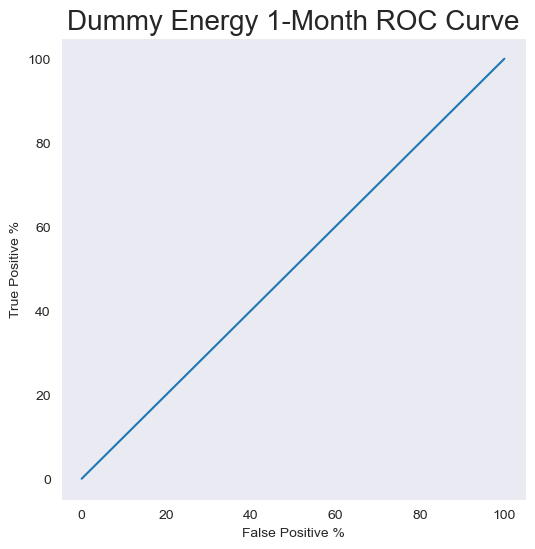

In [543]:
Energy.model_list[0].roc_curve()

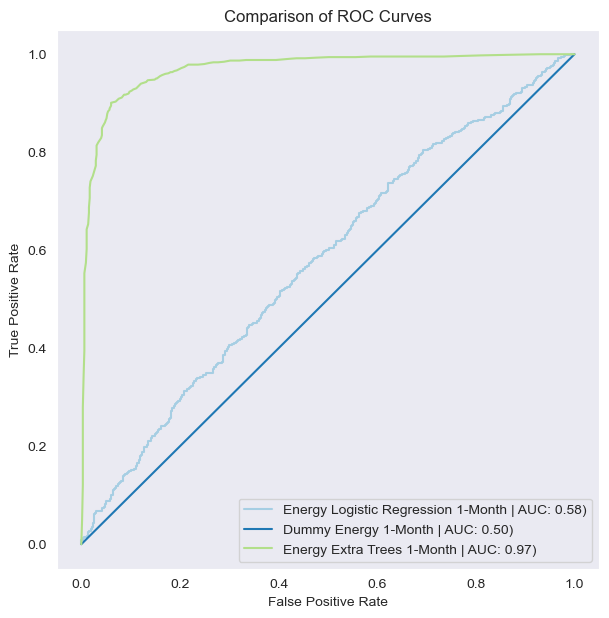

In [547]:
compare_curves([logreg3, Energy.model_list[0], etc3])

In [614]:
# Best overall models

all_data.sort_values(by="test_accuracy", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
28,"GridSearched PIPELINE(STEPS=[('CT',\n ...",0.979024,0.986948,0.983155,0.985039,0.060795,0.985274,0.990602,0.988743,0.989671,0.092646,0.996232
266,Communication_Services Extra Trees 12-Month,0.982578,0.983815,0.990826,0.987154,0.092066,0.985075,0.982955,0.994253,0.988571,0.049172,0.998961
265,Communication_Services Random Forest 12-Month,0.977609,0.976476,0.990826,0.983553,0.063403,0.985075,0.977528,1.000000,0.988636,0.060206,0.997402
262,"GridSearched Best-Model, 6-Month Communication...",0.978882,0.981666,0.983505,0.982520,0.130085,0.985075,1.000000,0.975758,0.987730,0.055740,0.997823
260,Communication_Services Extra Trees 6-Month,0.976390,0.977591,0.983505,0.980512,0.118715,0.985075,1.000000,0.975758,0.987730,0.047281,0.998970


In [616]:
all_data.loc[28, 'name']

"GridSearched PIPELINE(STEPS=[('CT',\n                 COLUMNTRANSFORMER(TRANSFORMERS=[('NUM_PIPE',\n                                                  PIPELINE(STEPS=[('SS',\n                                                                   STANDARDSCALER())]),\n                                                  <SKLEARN.COMPOSE._COLUMN_TRANSFORMER.MAKE_COLUMN_SELECTOR OBJECT AT 0X7FDDAD77B460>),\n                                                 ('CAT_PIPE',\n                                                  PIPELINE(STEPS=[('OHE',\n                                                                   ONEHOTENCODER(HANDLE_UNKNOWN='IGNORE',\n                                                                                 SPARSE_OUTPUT=FALSE))]),\n                                                  <SKLEARN.COMPOSE._COLUMN_TRANSFORMER.MAKE_COLUMN_SELECTOR OBJECT AT 0X7FDDAD779480>)])),\n                ('MODEL', EXTRATREESCLASSIFIER(RANDOM_STATE=13))]), 12-Month Materials"

# 4 out of 5 Top Models are in Communications Services

In [626]:
Materials.model_list[-1].name = "GridSearch ETC 12-Month Materials"

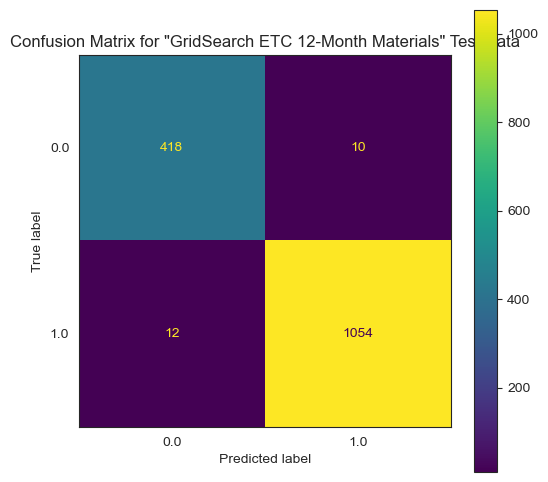

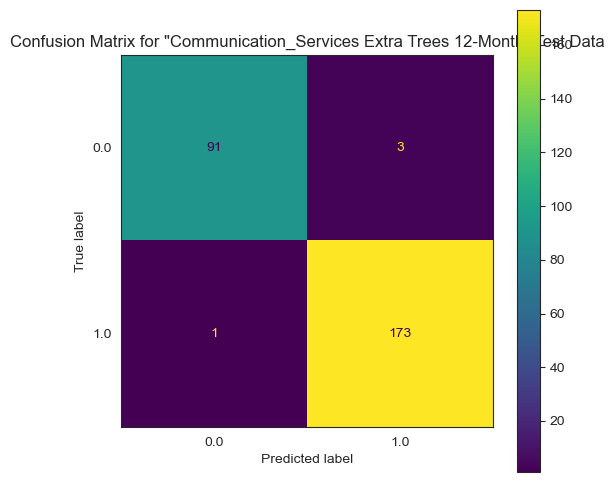

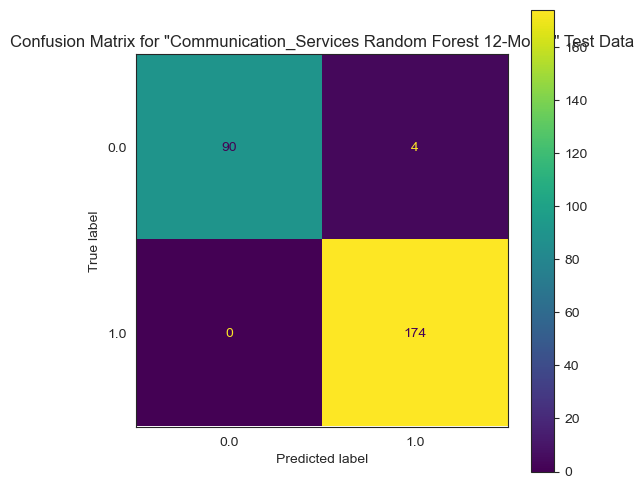

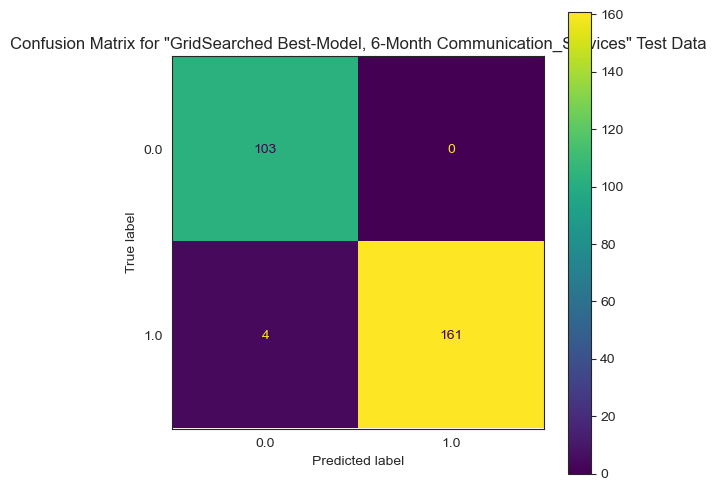

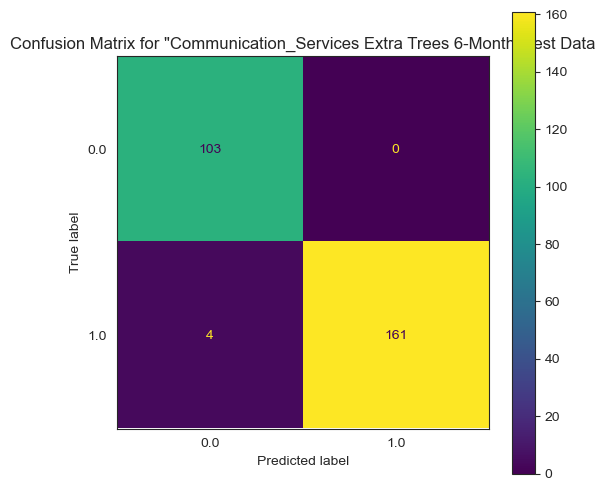

In [627]:
top_5_models = [Materials.model_list[-1], etc_CSrv_12, rfc_CSrv_12, grid_CSrv_6, etc_CSrv_6]
for i in top_5_models:
    i.confusion_matrix()

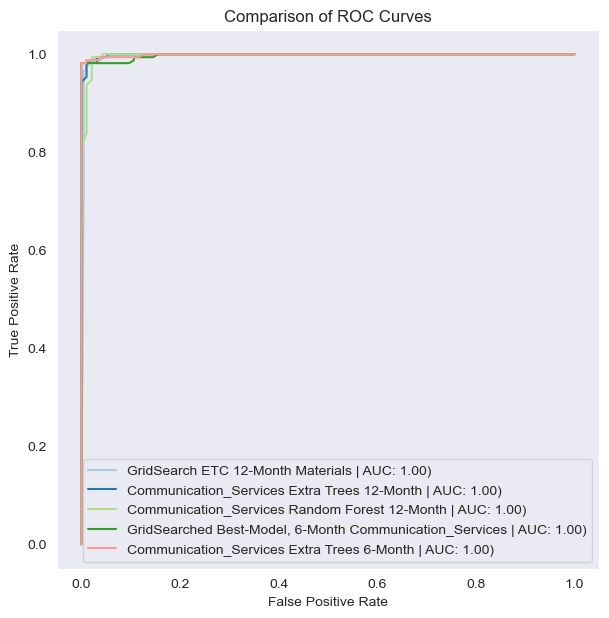

In [630]:
compare_curves(top_5_models)

In [645]:
# 12 Month Materials most important features

Importance.df.loc[Importance.df.index.str.contains("XLB")].T['12_Month XLB'].sort_values(ascending=False)[:10]

GDP                      0.075225
cycle_year_1             0.072214
Interest Rates           0.069435
upper_bollinger_band     0.058175
one_up_bollinger_band    0.053646
High                     0.053459
Close                    0.052454
Adj Close                0.050597
lower_bollinger_band     0.049639
garman_klass_vol         0.049184
Name: 12_Month XLB, dtype: float64

In [643]:
# 6 Month Comms Services most important factors

Importance.df.loc[Importance.df.index.str.contains("Communication")].T["Communication Services 6-Month"].sort_values(ascending=False)[:10]

GDP                      0.116671
upper_bollinger_band     0.081155
cycle_year_2             0.080549
one_up_bollinger_band    0.070177
Interest Rates           0.061487
lower_bollinger_band     0.053542
20_day_SMA               0.052581
Open                     0.050859
Close                    0.050148
High                     0.047333
Name: Communication Services 6-Month, dtype: float64

In [644]:
# 12 Month Comms Services most important factors

Importance.df.loc[Importance.df.index.str.contains("Communication")].T["Communication Services 12-Month"].sort_values(ascending=False)[:10]

upper_bollinger_band     0.157036
one_up_bollinger_band    0.120602
20_day_SMA               0.108990
lower_bollinger_band     0.078005
lowest_bollinger_band    0.071243
High                     0.058871
Close                    0.058153
Interest Rates           0.054105
Adj Close                0.053545
Open                     0.043598
Name: Communication Services 12-Month, dtype: float64

# Plotting Trees

After considering how difficult it would be to align each node with its actual splits, I have decided to rely on my feature importance collection created in the Importance() class.

In [555]:
from sklearn.tree import plot_tree

In [617]:
features = (Energy.model_list[23].model.named_steps["ct"].get_feature_names_out())
features_cleaned = [i.replace('num_pipe__', "").replace('cat_pipe__', "") for i in features]
features_cleaned[:5]

['Adj Close', 'Close', 'High', 'Low', 'Open']

In [651]:
Energy.model_list[23].name

'GridSearched Best-Model, 12-Month Energy'

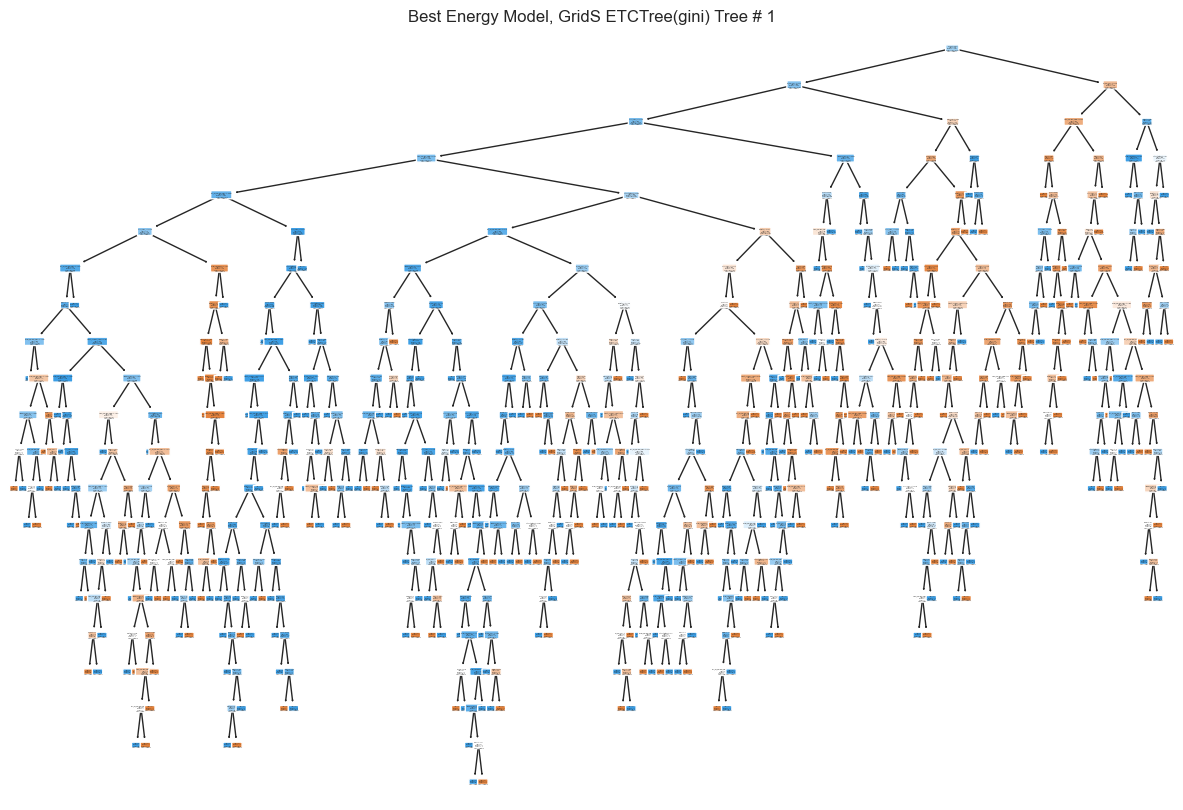

In [652]:
# Visualize the structure of one of the decision trees (e.g., the first tree)
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
plot_tree(Energy.model_list[23].model.named_steps["model"].estimators_[0], filled=True, \
          feature_names=features_cleaned, class_names=["Class 0", "Class 1"], rounded=True)
plt.title("Best Energy Model, GridS ETCTree(gini) Tree # 1")
plt.show()

In [618]:
Energy.model_df.sort_values(by="test_accuracy", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Energy",0.980361,0.983175,0.987150,0.985152,0.063432,0.980589,0.982249,0.989076,0.985651,0.056005,0.998331
21,Energy Extra Trees 12-Month,0.979468,0.982168,0.986812,0.984482,0.068770,0.980589,0.981299,0.990070,0.985665,0.055483,0.998220
20,Energy Random Forest 12-Month,0.974559,0.977501,0.984106,0.980788,0.076852,0.976573,0.978346,0.987090,0.982699,0.071217,0.997273
22,Energy XGBoost 12-Month,0.970987,0.974820,0.981399,0.978094,0.087563,0.971888,0.973503,0.985104,0.979269,0.083846,0.996035
17,"GridSearched Best-Model, 6-Month Energy",0.964739,0.975521,0.969359,0.972410,0.133980,0.968541,0.974950,0.977889,0.976417,0.093572,0.995605


# Time Stats for y_preds == 1

In [740]:
Energy.model_list[23].X_test

,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),GDP,Interest Rates,Mkt-RF,SMB,HML,RMW,CMA,Quarter,cycle_year
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-16,69.142426,100.320000,100.360001,99.199997,99.230003,8167400.0,-0.050351,61.648384,67.863704,68.329122,68.794540,69.259959,69.725377,0.969786,0.478896,564.7138,17192.019,0.0002,0.0032,-0.0060,0.0036,0.0018,0.0016,3,2
2022-08-18,75.785782,79.480003,79.559998,78.120003,78.260002,23433000.0,-0.000232,57.574576,67.609407,69.784115,71.958823,74.133531,76.308239,2.477345,1.036360,1775.8882,24654.603,0.0261,0.0027,0.0035,0.0046,0.0079,0.0008,3,2
2018-05-30,58.681026,76.599998,76.940002,74.959999,74.989998,23022200.0,-0.022893,57.596273,55.720652,57.057584,58.394515,59.731447,61.068378,1.425199,0.736155,1350.9663,20037.088,0.0190,0.0131,0.0004,0.0037,-0.0072,0.0018,2,2
2010-12-01,41.664169,64.570000,64.720001,63.740002,63.740002,19973800.0,-0.069714,65.429662,39.228032,39.830361,40.432690,41.035019,41.637348,1.250325,0.673937,832.1918,15309.474,0.0016,0.0212,-0.0010,0.0000,-0.0039,0.0037,4,2
2017-01-03,56.082924,76.169998,76.809998,75.360001,76.110001,24623100.0,-0.035836,60.249312,55.155633,55.564350,55.973067,56.381784,56.790501,1.032110,0.635485,1380.9354,19089.379,0.0053,0.0083,-0.0011,0.0006,-0.0020,0.0026,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-03,54.043438,73.400002,73.779999,72.629997,73.059998,11828600.0,-0.034990,46.439018,53.318475,53.971599,54.624724,55.277848,55.930972,0.989261,-0.361579,639.2582,19089.379,0.0050,0.0082,0.0062,0.0075,-0.0050,0.0031,1,1
2010-11-12,40.612400,62.939999,63.480000,62.380001,63.180000,17874300.0,-0.075286,70.820151,36.822095,37.931162,39.040228,40.149294,41.258360,1.051431,1.012710,725.9182,15309.474,0.0013,-0.0129,-0.0047,-0.0005,0.0017,-0.0004,4,2
2019-02-28,51.143764,65.250000,66.010002,64.839996,65.919998,11249400.0,-0.024723,55.107499,49.315728,50.130398,50.945067,51.759737,52.574406,1.076548,0.661178,575.3367,20917.867,0.0240,-0.0031,-0.0002,-0.0024,0.0029,0.0016,1,3


In [739]:
targets = df[df["Ticker"] == 'XLE'][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', 'Twelve_Month_Change']]

In [745]:
try_out_df = Energy.model_list[23].X_test.join(targets)

In [753]:
predictions = list(Energy.model_list[23].y_pred)

In [754]:
try_out_df["Y_PREDS"] = predictions
try_out_df.head(2)

,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),GDP,Interest Rates,Mkt-RF,SMB,HML,RMW,CMA,Quarter,cycle_year,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change,Y_PREDS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-07-16,69.142426,100.320000,100.360001,99.199997,99.230003,8167400.0,-0.050351,61.648384,67.863704,68.329122,68.794540,69.259959,69.725377,0.969786,0.478896,564.7138,17192.019,0.0002,0.0032,-0.0060,0.0036,0.0018,0.0016,3,2,-0.036782,-0.178409,-0.241559,-0.250746,0.0
2022-08-18,75.785782,79.480003,79.559998,78.120003,78.260002,23433000.0,-0.000232,57.574576,67.609407,69.784115,71.958823,74.133531,76.308239,2.477345,1.036360,1775.8882,24654.603,0.0261,0.0027,0.0035,0.0046,0.0079,0.0008,3,2,-0.012500,0.165438,0.080296,0.163271,1.0


In [761]:
try_out_df[try_out_df["Y_PREDS"] == 1][['One_Month_Change', 'Three_Month_Change',
       'Six_Month_Change', 'Twelve_Month_Change']].describe()

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,1014.000000,1014.000000,1014.000000,1014.000000
mean,0.022356,0.068303,0.129365,0.259073
std,0.071422,0.107046,0.135993,0.185235
min,-0.353647,-0.241060,-0.225253,-0.039360
25%,-0.020025,0.002462,0.042883,0.125241
50%,0.023064,0.056387,0.109650,0.219052
75%,0.064840,0.125398,0.200028,0.358770
max,0.327986,0.579674,0.774847,1.113624


In [762]:
df.head(2)

,Ticker,Adj Close,Close,High,Low,Open,Volume,garman_klass_vol,RSI,lowest_bollinger_band,lower_bollinger_band,20_day_SMA,one_up_bollinger_band,upper_bollinger_band,ATR,MACD,dollar_volume(M),...,HML,RMW,CMA,one_months_later,three_months_later,six_months_later,twelve_months_later,One_Month_Positive,Three_Month_Positive,Six_Month_Positive,Twelve_Month_Positive,Quarter,cycle_year,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-01-29,XLB,12.173974,21.109375,21.109375,20.953125,20.953125,400.0,-0.113866,45.359138,11.895115,12.260721,12.626327,12.991933,13.357539,0.428209,-0.181912,0.0049,...,-0.0062,0.0044,-0.0057,1999-03-01,1999-04-29,1999-07-29,2000-01-31,1.0,1.0,1.0,1.0,1,3,0.003701,0.304892,0.224778,0.120443
1999-01-29,XLE,11.670676,21.812500,21.812500,21.437500,21.687500,18600.0,-0.148177,31.112282,11.538889,11.886099,12.233308,12.580518,12.927728,0.420353,-0.327213,0.2171,...,-0.0062,0.0044,-0.0057,1999-03-01,1999-04-29,1999-07-29,2000-01-31,0.0,1.0,1.0,1.0,1,3,-0.018625,0.321352,0.294085,0.272486


In [764]:
Energy.model_list[5].name

'GridSearched Best-Model, 1-Month Energy'

In [765]:
Energy.model_df.iloc[:6].sort_values(by="test_accuracy", ascending=False)

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
5,"GridSearched Best-Model, 1-Month Energy",0.906715,0.914735,0.923315,0.918987,0.271652,0.914993,0.928656,0.920991,0.924808,0.239967,0.969846
3,Energy Extra Trees 1-Month,0.905601,0.913060,0.923317,0.918089,0.266331,0.914324,0.925532,0.923349,0.924439,0.264940,0.969174
2,Energy Random Forest 1-Month,0.884398,0.884228,0.918643,0.901070,0.348565,0.890228,0.891304,0.918632,0.904762,0.323588,0.953783
4,Energy XGBoost 1-Month,0.837532,0.849890,0.870382,0.859845,0.435341,0.845382,0.858304,0.871462,0.864833,0.417102,0.911323
1,Energy Logistic Regression 1-Month,0.569291,0.584381,0.861042,0.696187,0.677679,0.570281,0.580595,0.875000,0.698024,0.674558,0.576213
0,Dummy Energy 1-Month,0.573310,0.573310,1.000000,0.728794,15.379481,0.567604,0.567604,1.000000,0.724167,15.585141,0.500000


In [806]:
def describe_predictions(model, ticker, df, cat=1):
    targets = df[df["Ticker"] == ticker][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                                         'Twelve_Month_Change']]

    combined_df = model.X_test.join(targets)
    predictions = list(model.y_pred)
    combined_df["Y_PREDS"] = predictions

    return combined_df[combined_df["Y_PREDS"] == cat][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change',\
                                                     'Twelve_Month_Change']].describe()

In [816]:
describe_predictions(Energy.model_list[5], "XLE", df, 0)

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,653.000000,653.000000,653.000000,653.000000
mean,-0.052505,-0.034669,-0.005166,0.043192
std,0.061966,0.119808,0.170799,0.250762
min,-0.556992,-0.599644,-0.555319,-0.509324
25%,-0.070320,-0.093086,-0.110593,-0.148314
50%,-0.040235,-0.025241,0.010344,0.025348
75%,-0.016723,0.033757,0.089450,0.201292
max,0.077553,0.306647,0.689210,0.821258


In [814]:
pd.Series(Energy.model_list[5].y_pred).value_counts()

1.0    841
0.0    653
Name: count, dtype: int64

In [817]:
Financials.model_df.sort_values(by="test_accuracy", ascending=False)[:5]

,name,train_accuracy,train_prec,train_recall,train_f1,train_logloss,test_accuracy,test_prec,test_recall,test_f1,test_logloss,AUC
23,"GridSearched Best-Model, 12-Month Financials",0.979469,0.983879,0.983866,0.983857,0.065058,0.981928,0.987368,0.984260,0.985812,0.053268,0.998809
21,Financials Extra Trees 12-Month,0.979023,0.981827,0.985269,0.983537,0.066500,0.981258,0.987355,0.983211,0.985279,0.055513,0.998686
22,Financials XGBoost 12-Month,0.967866,0.974769,0.974749,0.974721,0.095076,0.979250,0.985263,0.982162,0.983710,0.066435,0.997269
20,Financials Random Forest 12-Month,0.972776,0.978630,0.978609,0.978597,0.094470,0.977912,0.986258,0.979014,0.982622,0.081450,0.997924
15,Financials Extra Trees 6-Month,0.963849,0.970263,0.972963,0.971603,0.140160,0.971888,0.980573,0.976578,0.978571,0.089501,0.995073


In [819]:
describe_predictions(Financials.model_list[23], "XLF", df)

,One_Month_Change,Three_Month_Change,Six_Month_Change,Twelve_Month_Change
count,950.000000,950.000000,950.000000,950.000000
mean,0.013592,0.048445,0.105341,0.203030
std,0.075443,0.106085,0.127367,0.159059
min,-0.391374,-0.433875,-0.284383,-0.019450
25%,-0.016996,0.001818,0.033155,0.097900
50%,0.016515,0.046507,0.093335,0.169777
75%,0.045444,0.097120,0.166316,0.269558
max,0.556485,0.736442,1.064366,1.199291
